Carson Dahlberg
July, 28 2018
## Capstone Proposal - Classifying Text Sentiment Polarity (positive vs. negative)
-----

# Workflow
1. Import Libraries
2. Data
  * Import the Data
  * Combine all three datasets into one
  * Split the data between train and test
  * Explore data - sanity checks (formats, stratefication, etc.)
3. Machine Learning Pipelines
  * Create a __Baseline Estimator__
  * Goal: Reproducible and Fast Iteration of Experiments
4. Modelling - First Iteration
  * Create baseline model(s)
  * Explore Common Practice Techniques 
  * Explore and Compare Results
5. Data Preprocessing Framework
  * Tokenizing - Documents -> Paragraphs -> Sentences -> Tokens
  * Denoising
  * Normalization
  * Feature Engineering
    * Engineered Word Features
    * Engineered Sentence Features
    * Engineered Document Features
6. Modelling - Second Iteration
  * Explore Hyperparam Tuning
  * Explore Combining Models (Voting)
  * Explore Improving Models with Feature Engineering
7. Voting Classifiers

-----

## Import Libraries
<a id="import_id"></a>


In [1]:
# helper functions for text cleanup, preprocessing and eature engineering
import helpers as h

contractions version: contractions 0.0.16
inflect version: inflect 0.3.1


In [2]:
import re, string, unicodedata
import os, glob, sys
import logging
from time import time
import datetime

import math
import numpy as np
np.random.seed(0) # set random seed for reproducibility
import pandas as pd
pd.set_option('display.width',4000)
pd.set_option('max_colwidth',4000)
pd.set_option('max_rows',100)
pd.set_option('max_columns',200)

import scipy as sp
import sklearn

import IPython
from IPython.core.display import display, HTML
from IPython.display import Image

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivey = "all"
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# which versions
print("Python version: {}".format(sys.version))
print("NumPy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("seaborn version: {}".format(sns.__version__))
print("SciPy version: {}".format(sp.__version__))
print("scikit-learn version: {}".format(sklearn.__version__))
print("IPython version: {}".format(IPython.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))

Python version: 3.5.5 | packaged by conda-forge | (default, Jul 24 2018, 01:52:17) [MSC v.1900 64 bit (AMD64)]
NumPy version: 1.13.1
pandas version: 0.20.3
seaborn version: 0.8.1
SciPy version: 0.19.1
scikit-learn version: 0.19.0
IPython version: 6.1.0
matplotlib version: 2.2.2


In [3]:
# additional smaller but useful libraries 
# contractions is capable of resolving contractions (and slang)
# could use to convert slang or create additional text
import contractions # expanding contractions here https://pypi.org/project/contractions/
print("contractions version: {}".format('contractions 0.0.16'))

# inflect.py - Correctly generate plurals, singular nouns, ordinals, indefinite articles; convert numbers to words.
# https://pypi.org/project/inflect/ 
import inflect # generating plurals, singular nouns, ordinals, indefinite articles, and converting numbers to words
print("inflect version: {}".format('inflect 0.3.1'))

contractions version: contractions 0.0.16
inflect version: inflect 0.3.1


In [4]:
import nltk
from nltk.corpus import stopwords

# custom tokenization for feature engineering using raw text
from nltk.tokenize import RegexpTokenizer

from nltk.tokenize import sent_tokenize # or can use
#from nltk.tokenize import PunktSentenceTokenizer # must be trained to be used
from nltk.tokenize import word_tokenize

from nltk.corpus import wordnet # for synonyms from WordNet

from nltk.stem import PorterStemmer # word stemming english words
from nltk.stem import SnowballStemmer # stemming non-English words
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer # another lemmatizer

from nltk.chunk import conlltags2tree, tree2conlltags # for nltk.Tree
from nltk import pos_tag
from nltk import ne_chunk
#from nltk.tag import StanfordPOSTagger  # another POS tagger

In [5]:
# must be connected to the internet
# download and unzip the files needed
nltk.download('stopwords')
nltk.download('punkt') # for sent_tokenize
nltk.download('wordnet') # for WordNet
nltk.download('averaged_perceptron_tagger') # for NER
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('nps_chat')

# call the english stopwords
len(stopwords.words('english')) # 179, but sklearn has +300

[nltk_data] Downloading package stopwords to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Carson Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roa

179

In [6]:
# scikit-learn nlp functionality
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print('sklearn total stop words: {}'.format(len(ENGLISH_STOP_WORDS)))

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, accuracy_score

# model persistence
from sklearn.externals import joblib
# joblib.dump(clf, 'filename.pkl') 
# clf = joblib.load('filename.pkl')
# result = clf.score(X_test, y_test)
# yhat = clf.predict(X)

sklearn total stop words: 318


In [7]:
# will use gensim to word2vec pre-trained model on a large corpus that
# has embeddings mapping similar words to each other
import gensim

C:\Anaconda3\envs\tf-nlp-gpu\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:
# for cleaning html and getting metadata if provided, like tags
from bs4 import BeautifulSoup

## Data - a brief description
<a id"#dat"></a>

#### Dataset for Classifying Text Sentiment Polarity (positive versus negative)
* DATA: [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)
* SOURCE/CITATION: Dimitrios Kotzias, This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015
* FORMAT: It contains sentences labelled with positive or negative sentiment. 
* DETAILS: Score is either 1 (for positive) or 0 (for negative)	The sentences come from three different websites/fields: imdb.com, amazon.com, and yelp.com. For each website, there exist 500 positive and 500 negative sentences. Those were selected randomly for larger datasets of reviews. We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected. 

-----
Set up where we're going to keep figures, in the project

In [9]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
TODAY = datetime.datetime.today().strftime('%Y-%m-%d')

# make sure all paths present
if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)
if not os.path.isdir(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "_" + TODAY + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_model(model, model_id, model_extension="pkl"):
    path = os.path.join(MODEL_PATH, model_id + "_" + TODAY + "." + model_extension)
    print("Saving model", model_id)
    joblib.dump(model, path) 

# test saving fig
#imdb_df.len.hist(bins=100)
#save_fig('test_save_img')
#plt.show()

## Data - get raw data
-----
We're interested in a generalizable model for classifying sentiment. To do so, we are using text data collected from social media reviews, from multiple social site sources: yelp.com, imdb.com, and amazon.com. These will capture different lengths of text, differing language usage, as well as language covering many domains.

In [10]:
from glob import glob
dir_reviews = r'./data/sentiment labelled sentences/sentiment labelled sentences'
review_files = glob(dir_reviews+'/*.txt')
review_files

['./data/sentiment labelled sentences/sentiment labelled sentences\\amazon_cells_labelled.txt',
 './data/sentiment labelled sentences/sentiment labelled sentences\\imdb_labelled.txt',
 './data/sentiment labelled sentences/sentiment labelled sentences\\readme.txt',
 './data/sentiment labelled sentences/sentiment labelled sentences\\yelp_labelled.txt']

In [11]:
# pandas read_table, etc not working properly because of multiline docs.
# this will also cleanup a lot of the whitespaces, newlines, etc.
def get_sentiment_data(file_name):
    data = []
    with open(file_name, 'r') as fh:
        review = ''
        for line in fh:
            if line[-2] in ['0', '1']:
                data.append(('' + review + line[:-3], line[-2]))
                review = ''
            else:
                review += ' ' + line
    return data

# get the data
imdb_data = get_sentiment_data(review_files[1])
imdb_df = pd.DataFrame(data=imdb_data, columns=['document','score'])
imdb_df['source'] = 'imdb'
imdb_df['len'] = imdb_df['document'].str.len()

amzn_data = get_sentiment_data(review_files[0])
amzn_df = pd.DataFrame(data=amzn_data, columns=['document','score'])
amzn_df['source'] = 'amazon'
amzn_df['len'] = amzn_df['document'].str.len()

yelp_data = get_sentiment_data(review_files[3])
yelp_df = pd.DataFrame(data=yelp_data, columns=['document','score'])
yelp_df['source'] = 'yelp'
yelp_df['len'] = yelp_df['document'].str.len()

### Data Observations:
* All reviews are pulled from the sources: __Amazon__ product reviews, __Yelp__ entertainment reviews, and __IMDb__ moview reviews.
* All data is in document format with some noted similarities and differences:
    * All data has a boolean indicator of 0 or 1 for target sentiment. 
    * __Amazon__ and __Yelp__ data are the most similar, with the minimum and maximum length of Yelp both roughly twice that of Amazon. 
    * __IMDb__ data is different in one *__major__* way, each document is made of one or more sentences. This will need to be considered when incorporating the data. 
    * Interestingly __IMDb__ has both the shortest document (made up of one sentence) and longest (made up of multiple sentences).
* Casual observations about sentiment:
  * In general, positive sentiment tends to be shorter, within the same datasets.
  * In general, negative sentiment tends to be longer, within the same datasets.


In [12]:
# what do some positive reviews look like?
yelp_df['document'][yelp_df['len'] == 11]#.tolist()

165    DELICIOUS!!
479    I LOVED it!
581    Over rated.
648    Great food.
663    Both great!
Name: document, dtype: object

In [13]:
# exploring the data
lst = [('amzn', amzn_df),
        ('yelp', yelp_df),
        ('imdb', imdb_df)]
for tup in lst:
    df_neg = pd.DataFrame()
    df_pos = pd.DataFrame()
    print('*'*55)
    print('--- {} review data ---\n'.format(tup[0]))
    tup[1].info()
    display(tup[1].head())
    print('')
    print('  SENTIMENT:')
    print('    * negative doc count {}'.format(tup[1]['score'].value_counts()[0]))
    print('    * positive doc count {}\n'.format(tup[1]['score'].value_counts()[1]))

    neg_sentiment = tup[1]['score'] == '0'
    df_neg = tup[1][neg_sentiment == True].copy()
    df_pos = tup[1][neg_sentiment == False].copy()
    max_neg = df_neg['len'].max()
    min_neg = df_neg['len'].min()
    max_pos = df_pos['len'].max()
    min_pos = df_pos['len'].min()
    
    print('  LENGTH:')
    print('    negative:')
    print('      * max of {} w/ idx is/are:\n {}'.format(max_neg, df_neg['document'][df_neg['len'] == max_neg]))
    print('      * min of {} w/ idx is/are :\n {}\n'.format(min_neg, df_neg['document'][df_neg['len'] == min_neg]))
    print('    positive:')
    print('      * max of w/ idx {} is/are:\n {}'.format(max_pos, df_pos['document'][df_pos['len'] == max_pos]))
    print('      * min of w/ idx {} is/are :\n {}\n'.format(min_pos, df_pos['document'][df_pos['len'] == min_pos]))

*******************************************************
--- amzn review data ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
document    1000 non-null object
score       1000 non-null object
source      1000 non-null object
len         1000 non-null int64
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


,document,score,source,len
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,amazon,82
1,"Good case, Excellent value.",1,amazon,27
2,Great for the jawbone.,1,amazon,22
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,amazon,79
4,The mic is great.,1,amazon,17



  SENTIMENT:
    * negative doc count 500
    * positive doc count 500

  LENGTH:
    negative:
      * max of 149 w/ idx is/are:
 65     The one big drawback of the MP3 player is that the buttons on the phone's front cover that let you pause and skip songs lock out after a few seconds.
532    Unfortunately it's easy to accidentally activate them with the gentle-touch buttons if you accidentally touch the phone to your face while listening.
Name: document, dtype: object
      * min of 11 w/ idx is/are :
 197    Bad Choice.
572    Worst ever.
Name: document, dtype: object

    positive:
      * max of w/ idx 148 is/are:
 98    Best I've found so far .... I've tried 2 other bluetooths and this one has the best quality (for both me and the listener) as well as ease of using.
Name: document, dtype: object
      * min of w/ idx 11 is/are :
 303    Good price.
666    Nice Sound.
689    Works well.
777    WORTHWHILE.
827    Good case!.
857    (It works!)
870    Works fine.
877    Excellent!.

,document,score,source,len
0,Wow... Loved this place.,1,yelp,24
1,Crust is not good.,0,yelp,18
2,Not tasty and the texture was just nasty.,0,yelp,41
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,yelp,87
4,The selection on the menu was great and so were the prices.,1,yelp,59



  SENTIMENT:
    * negative doc count 500
    * positive doc count 500

  LENGTH:
    negative:
      * max of 149 w/ idx is/are:
 985    The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).
Name: document, dtype: object
      * min of 11 w/ idx is/are :
 581    Over rated.
Name: document, dtype: object

    positive:
      * max of w/ idx 148 is/are:
 549    My boyfriend and I came here for the first time on a recent trip to Vegas and could not have been more pleased with the quality of food and service.
Name: document, dtype: object
      * min of w/ idx 11 is/are :
 165    DELICIOUS!!
479    I LOVED it!
648    Great food.
663    Both great!
Name: document, dtype: object

*******************************************************
--- imdb review data ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
document    1000 non-null object

,document,score,source,len
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,imdb,87
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,imdb,99
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,imdb,188
3,Very little music or anything to speak of.,0,imdb,44
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,imdb,108



  SENTIMENT:
    * negative doc count 500
    * positive doc count 500

  LENGTH:
    negative:
      * max of 321 w/ idx is/are:
 428    The use of slow-motion needlessly repeats itself throughout the movie but is well backed up by bad acting (and bad is a kind word here), no continuity, scenes that are thrown in for no reason whatsoever, vehicles that looked like they were made from a Corn Flakes box and a directorial style that bordered on stupidity.  
Name: document, dtype: object
      * min of 8 w/ idx is/are :
 162    Awful.  
Name: document, dtype: object

    positive:
      * max of w/ idx 479 is/are:
 620    This is a masterful piece of film-making, with many themes simmering and occasionally boiling over in this warts and all study of the poet's bohemian, self-indulgent wartime years that span the aerial bombardments of London and the outward tranquillity of a Welsh coastal retreat - the borderlines between friendship, lust and love, dedication to art and experience versus

### Split data between training and testing
-----

#### Combine all three data sets, then check
We will create a dataframe with all of the reviews, their sentiment scores, and the length. Later we can add the predictions for later comparison between models and inspecting differences between successful/failed predictions.

In [14]:
frames = []
frames = [imdb_df, amzn_df, yelp_df]
all_reviews = pd.concat(frames, ignore_index=True, axis=0)
all_reviews['score'] = all_reviews['score'].astype(int)
all_reviews.info()
display(all_reviews.head())
print('counts for each source:')
print(all_reviews['source'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
document    3000 non-null object
score       3000 non-null int32
source      3000 non-null object
len         3000 non-null int64
dtypes: int32(1), int64(1), object(2)
memory usage: 82.1+ KB


,document,score,source,len
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,imdb,87
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,imdb,99
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,imdb,188
3,Very little music or anything to speak of.,0,imdb,44
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,imdb,108


counts for each source:
yelp      1000
imdb      1000
amazon    1000
Name: source, dtype: int64


In [15]:
# save combined data 
path = os.path.join(DATA_PATH, "combined_raw_data_" + TODAY + ".csv")
all_reviews[['document','score','source']].to_csv(path, index=0)

In [16]:
# save combined data 
path = os.path.join(DATA_PATH, "combined_raw_data_" + TODAY + ".csv")
all_reviews[['document','score','source']].to_csv(path, index=0)

In [17]:
# create cleaned up, preprocessed tokens to be used by all three models. 
# %%timeit # 9.09 s ± 339 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# custom tokenization and preprocessing
# note: h.normalize revoves non-ascii words, converts to lower case, removes punct, 
#       replaces numbers with words, and removes stopwords
all_reviews['tokens'] = all_reviews["document"].apply(h.denoise_text) \
                                                .apply(h.replace_contractions) \
                                               .apply(nltk.word_tokenize) \
                                               .apply(h.normalize) \
                                               .apply(h.lemmatize_verbs)
all_reviews[['document','tokens']].head()

,document,tokens
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.","[slowmoving, aimless, movie, distress, drift, young, man]"
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.","[sure, lose, flat, character, audience, nearly, half, walk]"
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.","[attempt, artiness, black, white, clever, camera, angle, movie, disappoint, become, even, ridiculous, act, poor, plot, line, almost, nonexistent]"
3,Very little music or anything to speak of.,"[little, music, anything, speak]"
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,"[best, scene, movie, gerardo, try, find, song, keep, run, head]"


In [18]:
# then split between train/test
# looks like the data is split relatively evenly between classes [0,1]
# checking that stratify and shuffle are, in fact, the default
X_train, X_test, y_train, y_test = train_test_split(all_reviews['tokens'].apply(' '.join),
                                                    all_reviews['score'],
                                                    random_state=42, 
                                                    test_size=0.2
                                                   )
print('TRAINING:')
print('  length of X_train: {}\n'.format(len(X_train)))
print("  Samples per class (training):\n{}\n".format(y_train.value_counts()))

print('TESTING:')
print('  length of : {}\n'.format(len(X_test)))
print("  Samples per class (training):\n{}\n".format(y_test.value_counts()))

TRAINING:
  length of X_train: 2400

  Samples per class (training):
0    1207
1    1193
Name: score, dtype: int64

TESTING:
  length of : 600

  Samples per class (training):
1    307
0    293
Name: score, dtype: int64



__NOTE:__ Even though the __`source`__ column has not been passed to __`train_test_split`__, the training data is stratified across __`source`__ and the __`target class`__.

In [19]:
print('Splits between target:\n----------------------')
print(X_train.to_frame().merge(all_reviews, 
                         how='inner', 
                         left_index=True, 
                         right_index=True).groupby(['source','score']).size())

Splits between target:
----------------------
source  score
amazon  0        398
        1        405
imdb    0        397
        1        386
yelp    0        412
        1        402
dtype: int64


__Split the data between train and test.__

## Data - understanding preprocessing steps
---- 

#### Goal - use a toy example to understand typical textual data cleaning and preprocessing effect.
* First, this is a quick runthrough of some of the preprocessing involved, and visualizing some samples of the output. 
* Second, this can help build an intuition on why the models may perform better/worse with or without such preprocessing.


In [20]:
# here, we start with a small selected sample
# take a sample to apply cleaning and preprocessing
sample = all_reviews.sample(frac=0.002, replace=False)

sample[['document','source']]

,document,source
311,"One more thing: I can tolerate political incorrectness very well, I'm all for artistic freedom and suspension of disbelief, but the Slavic female character was just too much.",imdb
1025,Great Pocket PC / phone combination.,amazon
1587,Also difficult to put on.I'd recommend avoiding this product.,amazon
2941,Probably not in a hurry to go back.,yelp
2980,"I have been to very few places to eat that under no circumstances would I ever return to, and this tops the list.",yelp
2078,Today is the second time I've been to their lunch buffet and it was pretty good.,yelp


#### After cleaning...
This step takes care of file headers & footers; HTML, XML, markup and metadata; extracting valuable data from formats like JSON, removing []

In [21]:
# next, apply cleaning and preprocessing
sample['document'].apply(h.denoise_text).to_frame()

,document
311,"One more thing: I can tolerate political incorrectness very well, I'm all for artistic freedom and suspension of disbelief, but the Slavic female character was just too much."
1025,Great Pocket PC / phone combination.
1587,Also difficult to put on.I'd recommend avoiding this product.
2941,Probably not in a hurry to go back.
2980,"I have been to very few places to eat that under no circumstances would I ever return to, and this tops the list."
2078,Today is the second time I've been to their lunch buffet and it was pretty good.


#### After removing contractions `"don't"` -> `"do not"` and tokenizing

In [22]:
# tokenization also splits punctuation into their own tokens
sample["document"].apply(h.replace_contractions) \
                  .apply(nltk.word_tokenize).to_frame()

,document
311,"[One, more, thing, :, I, can, tolerate, political, incorrectness, very, well, ,, I, am, all, for, artistic, freedom, and, suspension, of, disbelief, ,, but, the, Slavic, female, character, was, just, too, much, .]"
1025,"[Great, Pocket, PC, /, phone, combination, .]"
1587,"[Also, difficult, to, put, on.I, would, recommend, avoiding, this, product, .]"
2941,"[Probably, not, in, a, hurry, to, go, back, .]"
2980,"[I, have, been, to, very, few, places, to, eat, that, under, no, circumstances, would, I, ever, return, to, ,, and, this, tops, the, list, .]"
2078,"[Today, is, the, second, time, I, have, been, to, their, lunch, buffet, and, it, was, pretty, good, .]"


#### After normalizing...
Normalization here includes removing non-ascii characters, changing all characters to lower case, removing punctuation, replacing numbers with words, then removing stop words.

In [23]:
sample["document"].apply(h.replace_contractions) \
                  .apply(nltk.word_tokenize) \
                  .apply(h.normalize).to_frame()

,document
311,"[one, thing, tolerate, political, incorrectness, well, artistic, freedom, suspension, disbelief, slavic, female, character, much]"
1025,"[great, pocket, pc, phone, combination]"
1587,"[also, difficult, put, oni, would, recommend, avoiding, product]"
2941,"[probably, hurry, go, back]"
2980,"[places, eat, circumstances, would, ever, return, tops, list]"
2078,"[today, second, time, lunch, buffet, pretty, good]"


#### After lemmatizing verbs, like "started" -> "start"...

In [24]:
sample["document"].apply(h.replace_contractions) \
                  .apply(nltk.word_tokenize) \
                  .apply(h.normalize) \
                  .apply(h.lemmatize_verbs).to_frame()

,document
311,"[one, thing, tolerate, political, incorrectness, well, artistic, freedom, suspension, disbelief, slavic, female, character, much]"
1025,"[great, pocket, pc, phone, combination]"
1587,"[also, difficult, put, oni, would, recommend, avoid, product]"
2941,"[probably, hurry, go, back]"
2980,"[place, eat, circumstances, would, ever, return, top, list]"
2078,"[today, second, time, lunch, buffet, pretty, good]"


Now that we have some intuition on how cleaning and preprocessing transforms the data, let's examine the benchmark model.

## Benchmark / Baseline - Naive Predictor Performance 
-----
*  simple baseline is just guessing the majority class (which in this case the dataset has been carefully selected to be balanced)
  * the guess should be 0.50 and the same for the f1 score (and this is what we see in the results below)
  
### Metrics
-----
**F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$
  
  * In particular, when $\beta = 0.5$, more emphasis is placed on precision. 
  * This is called the **F$_{0.5}$ score** (or F-score for simplicity). [Precision and Recall wikipeadia](https://en.wikipedia.org/wiki/Precision_and_recall)
  

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

$$ Accuracy = \frac{tn + tp}{tp + tn + fp + fn} $$


** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

$$ Precision = \frac{tp}{tp + fp} $$

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

$$ Recall = \frac{tp}{tp + fn} $$

In [25]:
y = all_reviews['score']
TP = np.sum(y) # Counting the ones as this is the naive case. 
#Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.

FP = y.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = float(TP + TN) / (TP + FP + TN + FN)
recall = float(TP) / (TP + FN)
precision = float(TP) / (TP + FP)
Beta = 0.5

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + Beta**2) * (precision * recall) / ((Beta**2 * precision) + recall)

# Print the results 
# format for model evals: accuracy = 0.768, precision = 0.770, recall = 0.768, f1 = 0.768
print("Naive Predictor:\naccuracy = {:.3f}, precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}".format(accuracy, 
                                                                                                      precision, 
                                                                                                      recall, 
                                                                                                      fscore))

Naive Predictor:
accuracy = 0.500, precision = 0.500, recall = 1.000, f1 = 0.556


## Baseline Model - Bag-of-Words + Logistic Regression
-----
* sklearn's simple count vectorization for BOWs
* using the some of the default __`sklearn`__ params for __`CountVectorizer`__
  * tokenizing - default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator)
  * default is lowercase=True
  * vocabulary building
  * sparse matrix encoding
  * using __`sklearn` `ENGLISH_STOP_WORDS`__ (note: `sklearn` has more stopwords than __`NLTL`__ out of the box)
* using some specified params for consistency between comparing models
  * setting max features to 10k
  * ignore terms w/ doc freq higher than threshold above 0.70
   * using 1 n-gram
* using the default __`sklearn`__ params for __`LogisticRegression`__
  * 
* using 5 fold cross validation


In [26]:
# CountVectorizer tokenizes and creates the .vocabulary_
vect = CountVectorizer(max_features=10000, 
                       max_df=0.70,          # ignore terms w/ doc freq higher than threshold
                       stop_words="english", # using sklearn's stopwords
                       ngram_range=(1, 1)     # using unigrams first
                      )
vect.fit(X_train)
#vect.fit(all_reviews['tokens'].apply(' '.join))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.7, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [27]:
# inspect vocabulary
print('vocab size: {}:'.format(len(vect.vocabulary_)))
print('vocab:\n{}'.format(vect.vocabulary_)) # this is very large...

vocab size: 3777:
vocab:
{'experience': 1157, 'degree': 854, 'worthless': 3738, 'rude': 2804, 'confirm': 683, 'deliver': 864, 'neil': 2192, 'pitiful': 2440, 'recess': 2664, 'pure': 2595, 'course': 744, 'portrayal': 2496, 'venture': 3579, 'factory': 1182, 'recommend': 2667, 'severe': 2936, 'hiro': 1557, 'charger': 525, 'folks': 1291, 'word': 3724, 'finest': 1245, 'shoot': 2967, 'disappointment': 922, 'instead': 1704, 'drool': 995, 'manage': 1988, 'destination': 881, 'interior': 1720, 'holder': 1565, 'wilkinson': 3694, 'commuter': 652, 'purity': 2597, 'scamp': 2850, 'loud': 1938, 'steele': 3143, 'sun': 3226, 'keypad': 1807, 'inconspicuous': 1664, 'male': 1982, 'leni': 1877, 'mere': 2056, 'man': 1987, 'industry': 1681, 'contrast': 713, 'cocktail': 616, 'stuff': 3186, 'mark': 2001, 'magic': 1970, 'energy': 1088, 'military': 2077, 'mclaglen': 2022, 'limitations': 1902, 'crusty': 790, 'buy': 434, 'mojitos': 2110, 'company': 654, 'usb': 3549, 'gloriously': 1411, 'energetic': 1087, 'yeah': 375

In [28]:
# create BOWs representation of data by tranformming
# and storing in a dense representation of stem_BOWs
BOWs_train = vect.transform(X_train)
print('bag of words:\n{}'.format(BOWs_train.toarray()))

bag of words:
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


__OBSERVATIONS:__
* lots of actual numbers, names and language plumbing/stop words
* these are possible areas for model improvement

In [29]:
feature_names = vect.get_feature_names()
print('num features: {}\n'.format(len(feature_names)))
print('features head: {}\n'.format(feature_names[:5]))
print('every 100th feature:\n{}\n'.format(feature_names[::100]))
print('features tail: {}'.format(feature_names[-5:]))

num features: 3777

features head: ['15lb', '18th', '20th', '20the', '2mp']

every 100th feature:
['15lb', 'aluminum', 'authentic', 'better', 'brownish', 'cell', 'click', 'construct', 'customer', 'difficult', 'dull', 'entire', 'far', 'footage', 'giant', 'happen', 'howeverthe', 'instal', 'kabuki', 'lilt', 'marion', 'mistake', 'nice', 'outdoor', 'periodically', 'possibility', 'puzzlesolving', 'relax', 'rpger', 'selfindulgent', 'sit', 'spicier', 'sublimely', 'teen', 'track', 'unfortunate', 'violence', 'windows']

features tail: ['zero', 'zillion', 'zombie', 'zombiestudents', 'zombiez']


__Build and Score the Baseline Model__

In [30]:
scores = cross_val_score(LogisticRegression(random_state=42), 
                         BOWs_train, # from X_train 
                         y_train, 
                         cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.79


In [31]:
# look at the range of model scores
scores

array([ 0.77546778,  0.78170478,  0.77708333,  0.79331942,  0.80375783])

__EXAMINE MODEL__
* how is the model making sentiment predictions?
* take a look at the top 20 coefficients for each feature to determine weighting towards pos/neg sentiment

__Observations:__ 
* This simple Bag of Words, unigram LogisticRegression model is doing a decent job.


* All of the __metrics__ (accuracy, precision, recal, and f1) are all essentially the same.  
  
* room for improvement would be 
  * ranges of ngrams
  * feature generation on the word or sentence level
  * trying several models
  * hyperparameter tuning

In [32]:
# look at the test score
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(BOWs_train, y_train)
BOWs_test = vect.transform(X_test)
y_predicted = lr_clf.predict(BOWs_test)

In [33]:
# unpack metrics using function
accuracy, precision, recall, f1 = h.get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.768, precision = 0.770, recall = 0.768, f1 = 0.768


In [34]:
# save models (CountVectorizer and Logistic Regression)
save_model(vect,'bows_default')
save_model(lr_clf,'logistic_regression_w_bows')

Saving model bows_default
Saving model logistic_regression_w_bows


### INSPECT MODEL - DATA VISUALIZATION


* visualize the top coefficients from the sklearn model
  * Looking at the top/bottom weightings helps to make sense and build and intuition of how the model works, which in turn completes the Qualitative aspect of measuring whether the algo is working as expected (i.e. that the patterns discovered have value and aren't lucky for the data).
  * Please note: the visualization for important features (top n features) was inspired from workshops attended and books read from Andreas Mueller, PhD. 

* The confusion matrix makes sense as well and demonstrates that the model is working, as advertized in the cross validation step of training and validating.
  * We do see, however, that the model makes slightly more mistakes with positive sentiment. It is likely that the mistakes are due to nuances in the English language such as 
    * user purpose – questions/requests mistaken as compliment/criticism?
    * Semantics/sentence structure/subtle language cues – jokes, sarcasm, rhetoric and literary devices
    * Atypical word usage like swearing used colloquially as a compliment
    * Errors due to mixed/conflicted sentiment (perhaps weightings would be better for tokens if more data were provided?)
      * This seemed like what using bi-grams might capture like `best_part` and `good_bargain` played a factor, as well as these types of phrases coupled with missing words like `not` which negate the meaning (samples are below).   
* look at the correct calls and mistakes the model is making
  * `source` == `imdb` had 50% more errors than the other sources, which would likely change over a larger dataset and more training. Another possiblity is that a more specific metalearner could improve the accuracy. This could be done by training a general learner on as much varied data as possible (sources/domains). Next, the metalearner would learn the patterns of a particular source and could likely perform better.
  * Mistakes are consistently made moreso with positive sentiment

In [35]:
# get the feature names
feature_names = np.array(vect.get_feature_names())
# find the max for each feature
max_val = BOWs_train.max(axis=0).toarray().ravel()
# sort the index
sorted_coef_index = max_val.argsort()
print('smallest coefficients/close to 0:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('largest coefficients/close to 1:\n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))

smallest coefficients/close to 0:
['15lb' 'poorly' 'pop' 'popcorn' 'popular' 'pork' 'port' 'portable'
 'portion' 'portraits' 'portray' 'portrayal' 'poor' 'portrayals' 'possesed'
 'possibility' 'possible' 'possibly' 'post' 'postproduction']

largest coefficients/close to 1:
['suck' 'scamp' 'bad' 'avoid' 'food' 'sound' 'wait' 'good' 'film' 'great'
 'angel' 'really' 'fly' 'appreciate' 'picture' 'area' 'real' 'character'
 'sense' 'emotions']


Saving figure bows_default_top_30_features


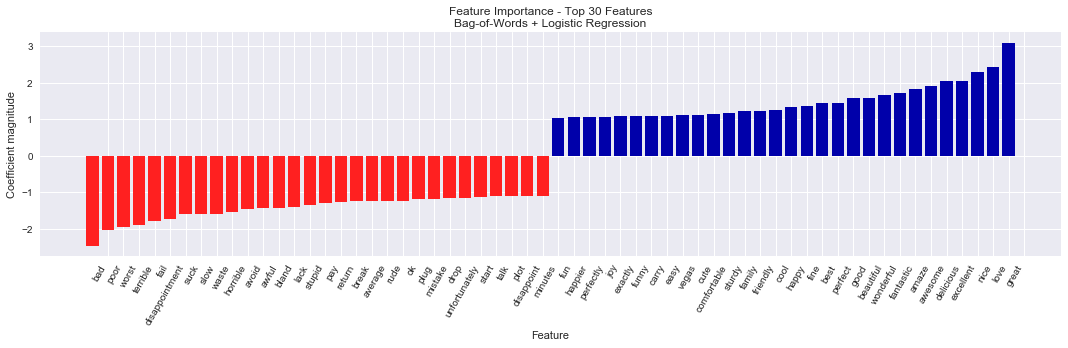

In [36]:
# viz of the top coefficients for the 
h.visualize_coefficients(coefficients=lr_clf.coef_,
                         feature_names=feature_names, 
                         n_top_features=30)
plt.title('Feature Importance - Top 30 Features\nBag-of-Words + Logistic Regression')
save_fig("bows_default_top_30_features")

Saving figure bows_default_confusion_matrix


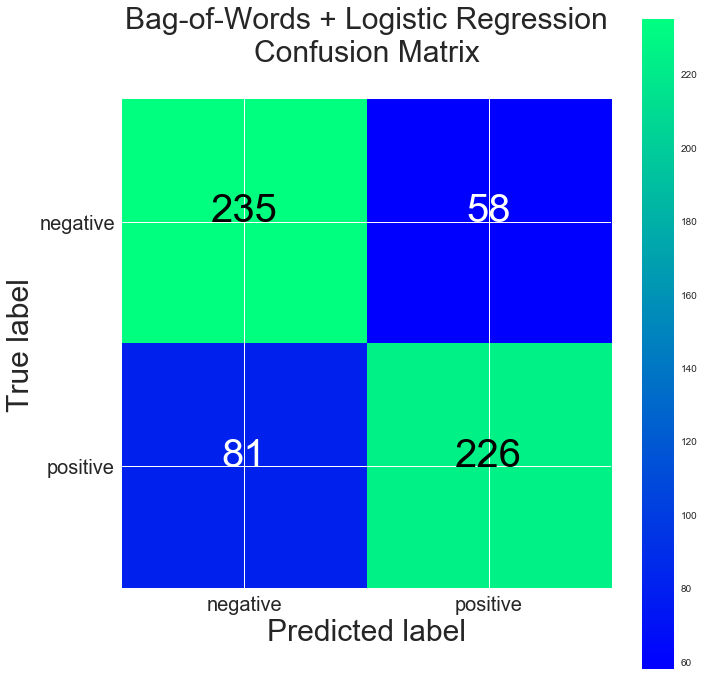

In [37]:
# create a confusion matrix
conf_matrix = h.confusion_matrix(y_test, y_predicted)

# plot the confusion matrix
fig = plt.figure(figsize=(10,10))
h.plot_confusion_matrix(conf_matrix,
                        classes=['negative','positive'], 
                        normalize=False, 
                        title='Bag-of-Words + Logistic Regression\nConfusion Matrix\n')

save_fig("bows_default_confusion_matrix",tight_layout=False)

In [38]:
# let's look at the incorrect predictions
# add the predictions of default BoWs to the all_reviews dataframe
# https://stackoverflow.com/questions/45176469/can-i-get-a-list-of-wrong-predictions-in-svm-score-function-in-scikit-learn?rq=1
#print(all_reviews['y_pred_def_bows'].count())
#all_reviews['y_pred_def_bows'] = lr_clf.predict(vect.transform(all['reviews'].astype(str)))
X_BoW = vect.transform(all_reviews['document'].as_matrix())
y_pred_def_bow = lr_clf.predict(X_BoW)
y_pred_prob_def_bow = lr_clf.predict_proba(X_BoW)

# predict over whole group with the model and compare to actual target
all_reviews['y_pred_def_bow'] = y_pred_def_bow
# predict probabilities to compare how close, confident the prediction was
all_reviews['y_pred_prob_def_bow_0'] = y_pred_prob_def_bow[:,0]
all_reviews['y_pred_prob_def_bow_1'] = y_pred_prob_def_bow[:,1]

#### Create boolean masks to examine the mistakes made by the LogisticRegression + Bag-of-Words model.

In [39]:
mistakes = all_reviews['score'] != all_reviews['y_pred_def_bow']
# observations: mistakes are consistently made with positive sentiment
# imdb had ~45-50% more errors, which could likely change over a larger dataset and more training
g = all_reviews[mistakes].groupby(['source','score'])['source'].size() / 500 #.plot(kind='bar')
g = pd.DataFrame(g).rename(columns={'source':'mistakes_pct'}).reset_index()
g

,source,score,mistakes_pct
0,amazon,0,0.106
1,amazon,1,0.112
2,imdb,0,0.092
3,imdb,1,0.170
4,yelp,0,0.094
5,yelp,1,0.124


Saving figure bows_default_top_30_features_mistakes


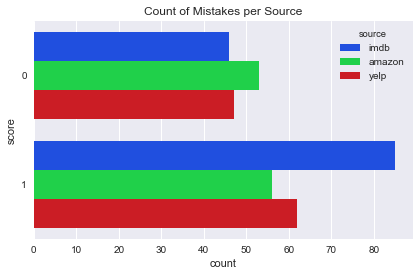

In [40]:
# plot the mistakes
ax = sns.countplot(y='score', 
                   hue='source', 
                   data=all_reviews[['source','score']][mistakes], 
                   palette='bright')
plt.title('Count of Mistakes per Source')
save_fig("bows_default_top_30_features_mistakes")
plt.show()

Let's manually investigate errors and see if we can come to any conclusions.

In [41]:
g = all_reviews[mistakes].groupby(['source','score'])['document']

# investigate a few mistakes <source><true_score>, ex. amazon 0 i== amazon negative but predicted positive 
for group in g.groups.keys():
    print('----- {} {} -----'.format(group[0],group[1]))
    print(g.get_group(group).values[:5])
    print()

----- yelp 1 -----
['The food, amazing.' 'So they performed.'
 'The only thing I did like was the prime rib and dessert section.'
 'He came running after us when he realized my husband had left his sunglasses on the table.'
 'Update.....went back for a second time and it was still just as amazing']

----- yelp 0 -----
['Crust is not good.'
 'The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.'
 'This place is not worth your time, let alone Vegas.'
 'did not like at all.'
 'There is so much good food in Vegas that I feel cheated for wasting an eating opportunity by going to Rice and Company.']

----- imdb 1 -----
['Waste your money on this game.  '
 'This is the kind of money that is wasted properly.  '
 'Totally believable.  ' 'I sat riveted to the TV screen.  '
 'All in all I give this one a resounding 9 out of 10.  ']

----- imdb 0 -----
['This short film certainly pulls no punches.  '
 'Graphics is far from the best part of the game.  

In [42]:
g = all_reviews[~mistakes].groupby(['source','score'])['document']

# investigate correct predictions <source><true_score>, ex. amazon 0 i== amazon negative but predicted positive 
for group in g.groups.keys():
    print('----- {} {} -----'.format(group[0],group[1]))
    print(g.get_group(group).values[:5])
    print()

----- yelp 1 -----
['Wow... Loved this place.'
 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.'
 'The selection on the menu was great and so were the prices.'
 'The fries were great too.' 'A great touch.']

----- yelp 0 -----
['Not tasty and the texture was just nasty.'
 'Now I am getting angry and I want my damn pho.'
 "Honeslty it didn't taste THAT fresh.)"
 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.'
 'Would not go back.']

----- imdb 1 -----
[ 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  '
 'Saw the movie today and thought it was a good effort, good messages for kids.  '
 'Loved the casting of Jimmy Buffet as the science teacher.  '
 'And those baby owls were adorable.  '
 "The movie showed a lot of Florida at it's best, made it look very appealing.  "]

----- imdb 0 -----
[ 'A very, very, very slow-moving, a

### Next, we'll examine a high confidence prediction vs. a low confidence prediction...

This will help to build intuition as to why a model is behaving the way it does.

High confidence predictions seem to be working well. It is also worth noting that the model was able to distinguish a word like 'waste' used in negative and positive context ("waste of my time" vs. "money wasted the right way").

In [43]:
# bools for viewing strong and weak predictions
neg_sentiment = (all_reviews['score'] == 0)
neg_high = all_reviews['y_pred_prob_def_bow_0'] > 0.75
pos_high = all_reviews['y_pred_prob_def_bow_1'] > 0.75
neg_close = all_reviews['y_pred_prob_def_bow_0'].between(0.5,0.6)
pos_close = all_reviews['y_pred_prob_def_bow_1'].between(0.5,0.6)

In [44]:
# negative sentiment predicted negative w/ high confidence
display(all_reviews[['document','score', 'y_pred_prob_def_bow_0']][neg_sentiment & neg_high][:5])

,document,score,y_pred_prob_def_bow_0
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,0.848500
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,0.881240
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,0.925928
15,"It had some average acting from the main person, and it was a low budget as you clearly can see.",0,0.943852
34,Today the graphics are crap.,0,0.879759


In [45]:
# and now positive sentiment predicted positive w/ high confidence
display(all_reviews[['document','score', 'y_pred_prob_def_bow_1']][~neg_sentiment & pos_high][:5])

,document,score,y_pred_prob_def_bow_1
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,0.762593
7,"Saw the movie today and thought it was a good effort, good messages for kids.",1,0.935799
12,The Songs Were The Best And The Muppets Were So Hilarious.,1,0.861086
16,"This review is long overdue, since I consider A Tale of Two Sisters to be the single greatest film ever made.",1,0.837607
17,"I'll put this gem up against any movie in terms of screenplay, cinematography, acting, post-production, editing, directing, or any other aspect of film-making.",1,0.887494


Low confidence predictions seem to be working well too, in this short anecdotl sample review.

In [46]:
# negative sentiment predicted negative with low confidence
display(all_reviews[['document','score', 'y_pred_prob_def_bow_0']][neg_sentiment & neg_close][:5])

,document,score,y_pred_prob_def_bow_0
5,"The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.",0,0.551179
8,A bit predictable.,0,0.596552
41,I wasn't the least bit interested.,0,0.599650
65,One character is totally annoying with a voice that gives me the feeling of fingernails on a chalkboard.,0,0.546862
105,Very disappointing.,0,0.599650


In [47]:
# positive sentiment predicted positive with low confidence
display(all_reviews[['document','score', 'y_pred_prob_def_bow_1']][~neg_sentiment & pos_close][:5])

,document,score,y_pred_prob_def_bow_1
9,Loved the casting of Jimmy Buffet as the science teacher.,1,0.545866
21,"In other words, the content level of this film is enough to easily fill a dozen other films.",1,0.582090
22,How can anyone in their right mind ask for anything more from a movie than this?,1,0.538962
29,It is an insane game.,1,0.502445
30,"There are massive levels, massive unlockable characters... it's just a massive game.",1,0.502445


## Scikit-Learn Baseline Model - TF-IDF Bag-of-Words + Logistic Regression
-----
* simple count vectorization for BOWs
* using the some of the default __`sklearn`__ params for __`CountVectorizer`__
  * tokenizing - default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator)
  * default is lowercase=True
  * vocabulary building
  * sparse matrix encoding
  * using __`sklearn` `ENGLISH_STOP_WORDS`__ (note: `sklearn` has more stopwords than __`NLTL`__ out of the box)
* using some specified params for consistency between comparing models
  * setting max features to 10k
  * ignore terms w/ doc freq higher than threshold above 0.70
   * using 1 n-gram
* using the default __`sklearn`__ params for __`LogisticRegression`__
  * 
* using 5 fold cross validation

### Rescaling the data with TFIDF
Instead of dropping features (words, etc.) that are assumed to be unimportant, another approach is to keep them all and rescale them. The rescaling is according to how informative they are expected to be. The basic assumption is that the more important terms are the ones which appear often in a particular document, but not in many documents in the corpus. Some intuition behind this idea is that if this condition holds, the term is likely very descriptive of that document. Here are some details on the variants of tf-idf on [wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

We can apply this with sklearn, which uses the following in the TfidfVectorizer classes:

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

  * _N_ is the number of docs in training set, 
  * $N_{w}$ is the num of docs in the training set
  * _w_ is the word
  * _tf_ is the word frequency, the num times _w_ appears in the document _d_
  
We'll use sklearn's TfidfVectorizer & Pipeline to apply this concept:
  * __`sublinear_df`__ True = use log frequency.
  * __`min_df`__ min num of docs a word must be present in to be kept.
  * __`norm`__ l2, to ensure all feature vectors have euclidian norm of 1.
  * __`ngram_range`__ (1, 2) for both unigrams and bigrams.
  * __`stop_words`__ "english" to reduce noisy features.

__Build and Score the Baseline Model__

In [48]:
# CountVectorizer tokenizes and creates the .vocabulary_
tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                             min_df=5, 
                             norm='l2', 
                             encoding='latin-1', 
                             ngram_range=(1, 2),   # using unigrams first
                             max_features=20000,   # same as CountVectorizer
                             stop_words="english"  # using sklearn's stopwords
                            )
tfidf_vect.fit(X_train)
tfidf_train = tfidf_vect.transform(X_train)

In [49]:
scores = cross_val_score(LogisticRegression(random_state=42), 
                         tfidf_train, # from X_train 
                         y_train, 
                         cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.78


In [50]:
# look at the range of model scores
scores

array([ 0.76299376,  0.79002079,  0.76041667,  0.78496868,  0.77661795])

In [51]:
# look at the test score
lr_clf_2 = LogisticRegression(random_state=42)
lr_clf_2.fit(tfidf_train, y_train)
tfidf_test = tfidf_vect.transform(X_test)
y_predicted = lr_clf_2.predict(tfidf_test)

In [52]:
# unpack metrics using function
accuracy, precision, recall, f1 = h.get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.755, precision = 0.756, recall = 0.755, f1 = 0.755


In [53]:
# save models (TfidfVectorizer and Logistic Regression)
save_model(tfidf_vect,'tfidf_default')
save_model(lr_clf_2,'logistic_regression_w_tfidf')

Saving model tfidf_default
Saving model logistic_regression_w_tfidf


__EXAMINE MODEL__
* how is the model making sentiment predictions?
* take a look at the top 20 coefficients for each feature to determine weighting towards pos/neg sentiment

__Observations:__ 
* This simple Bag of Words, unigram LogisticRegression model is doing a slightly better job than the TFIDF BOWs, unigram LogisticRegression model.

* Again, all __metrics__ being used to measure model performance are essentially equal.

* room for improvement would be the same as the first baseline model:
  * ranges of ngrams
  * feature generation on the word or sentence level
  * trying several models
  * hyperparameter tuning

### Inspect the which words tf-idf found important
* this is unsupervised
* this doesn't necessarily mean best fit to our negative/positive sentiment

Low tf-idf was either common across many documents or used sparingly. The high tf-idf likely describe particular nouns/topics/documents.

In [54]:
# max val of each feature over documents
max_val = tfidf_train.max(axis=0).toarray().ravel()
# create an index
sorted_by_tfidf = max_val.argsort()

# get the feature names
feature_names = np.array(tfidf_vect.get_feature_names())

labels = y_train

# sort and inspect
print('low tf-idf features:\n{}\n'.format(feature_names[sorted_by_tfidf[:100]]))

print('high tf-idf features:\n{}\n'.format(feature_names[sorted_by_tfidf[-100:]]))

low tf-idf features:
['years ago' 'ago' 'thirty minutes' 'server' 'open' 'twice' 'range'
 'contain' 'cartoon' 'sense' 'pretty good' 'clever' 'wife' 'cause'
 'obviously' 'serve' 'edit' 'look like' 'customer' 'customer service'
 'cell phone' 'number' 'definitely worth' 'motorola' 'rare' 'comedy' 'beer'
 'play' 'meat' 'offer' 'verizon' 'head' 'certainly' 'drink' 'warm'
 'plastic' 'child' 'mean' 'life' 'anytime' 'anytime soon' 'roll'
 'watch film' 'despite' 'force' 'change' 'season' 'food service' 'run'
 'list' 'make feel' 'tv' 'phone work' 'wow' 'seven' 'cut' 'extra'
 'battery life' 'area' 'piece junk' 'especially' 'mess' 'sound quality'
 'literally' 'eighty' 'ability' 'spicy' 'headphones' 'live' 'waste money'
 'pull' 'tell' 'highly recommend' 'cinematography' 'large' 'sit' 'face'
 'let' 'sushi' 'dance' 'easily' 'clip' 'allow' 'bluetooth headset'
 'recently' 'helpful' 'lot' 'start' 'film great' 'really good' 'smell'
 'fall' 'consider' 'rest' 'eye' 'rice' 'days' 'like movie' 'decent'
 'lit

__Observations:__ Words with low tf-idf are used very little. 

### low inverse document frequency
* Inspecting the *idf_* attribute
* appear frequently are assumed less important

The ones (in the below output) appear to be stopwords and pronouns, the "plumbing" of the English language. Although, as a human, I would be surprised if certain words did not relate to positive/negative sentiment, like:
  * excellent, great, love, dissappointed, better, recommend, horribly, avoid, awesome, wonderful

__`love`__ is particulary interesting because __`loved`__ is listed in the tf-idf document

There are also some issues with the parsing in sklearn, that nltk could likely handle better, or pass a custom parser to sklearn.CountVectorizer or TfidfVectorizer. From the tf-idf and idf analysis here are some obscure terms to me as a human, that perhaps reflect loss of information:
  * ve (likley a contraction)
  * re
  
Additionally, the lowest idf terms consist of some domain terms like 
  * plot, characters, movie, vegas
  * product, headset, staff
  * restaurant, sushi, flavor

In [55]:
sorted_by_idf = np.argsort(tfidf_vect.idf_)
print('low idf features:\n{}\n'.format(feature_names[sorted_by_idf[:300]]))

low idf features:
['good' 'great' 'phone' 'film' 'movie' 'work' 'like' 'time' 'place' 'make'
 'food' 'service' 'really' 'use' 'love' 'bad' 'best' 'come' 'quality'
 'look' 'think' 'disappoint' 'sound' 'say' 'product' 'character' 'price'
 'better' 'recommend' 'headset' 'excellent' 'nice' 'watch' 'buy' 'pretty'
 'act' 'way' 'battery' 'waste' 'try' 'little' 'amaze' 'feel' 'want' 'eat'
 'case' 'worst' 'know' 'right' 'end' 'play' 'friendly' 'order' 'thing'
 'terrible' 'far' 'thousand' 'ear' 'movies' 'story' 'plot' 'piece' 'poor'
 'real' 'people' 'definitely' 'experience' 'minutes' 'lot' 'money' 'new'
 'star' 'years' 'worth' 'fit' 'quite' 'life' 'cast' 'need' 'expect' 'happy'
 'charge' 'work great' 'vegas' 'wonderful' 'absolutely' 'delicious' 'wait'
 'probably' 'totally' 'restaurant' 'enjoy' 'cool' 'fine' 'awful' 'job'
 'bite' 'music' 'horrible' 'camera' 'leave' 'big' 'impress' 'easy' 'hear'
 'set' 'family' 'write' 'script' 'screen' 'car' 'lack' 'awesome' 'tell'
 'taste' 'turn' 'comfortable' 

__INSPECT MODEL - DATA VISUALIZATION__
* look at the correct calls and mistakes the model is making
* use the confusion matrix
* visualize the top coefficients from the sklearn model

Saving figure tfidf_default_top_30_features


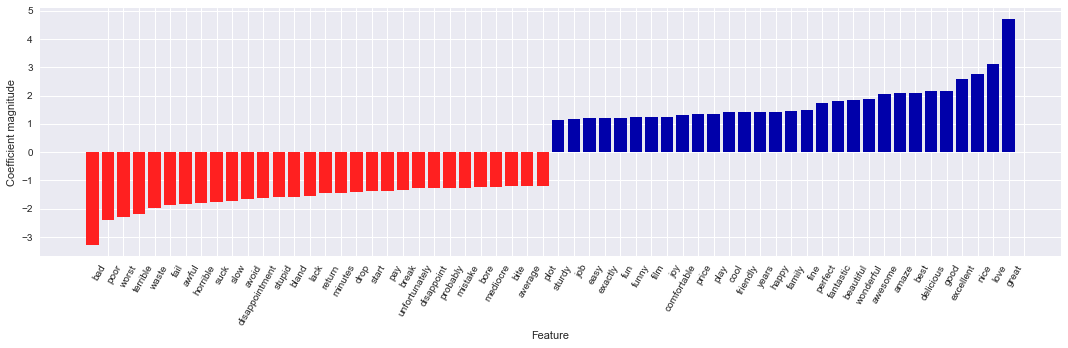

In [56]:
# viz of the top coefficients for the TFIDF Model
h.visualize_coefficients(coefficients=lr_clf_2.coef_,
                         feature_names=feature_names,
                         n_top_features=30)

save_fig("tfidf_default_top_30_features")

Saving figure bows_default_confusion_matrix


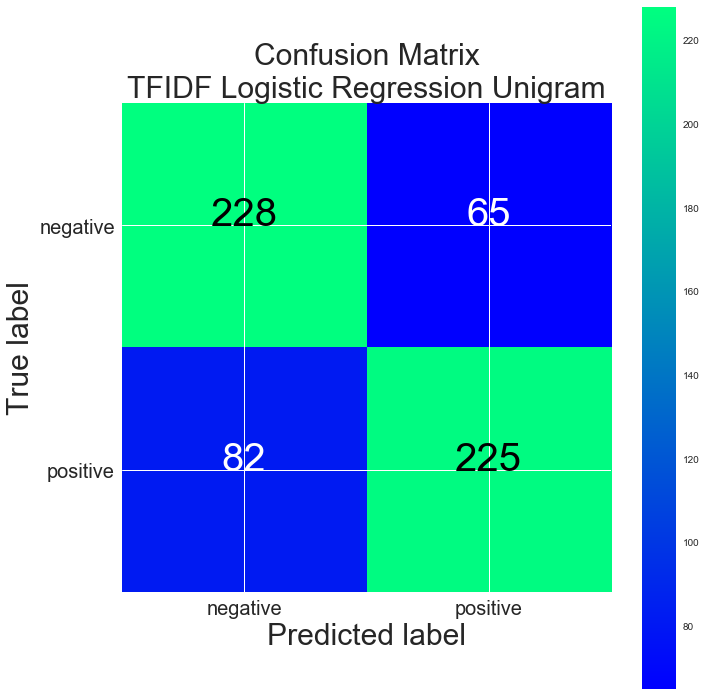

In [57]:
# create a confusion matrix
conf_matrix = h.confusion_matrix(y_test, y_predicted)

# plot the confusion matrix
fig = plt.figure(figsize=(10,10))
h.plot_confusion_matrix(conf_matrix,
                        classes=['negative','positive'], 
                        normalize=False, 
                        title='Confusion Matrix\nTFIDF Logistic Regression Unigram')

save_fig("bows_default_confusion_matrix",tight_layout=False)

### Investigate mistakes, high and low confidence predictions

We will do a similar analysis that was conducted with the Baseline Logistic Regression on BoWs.

In [58]:
# let's look at the incorrect predictions
# add the predictions of default TF-IDF to the all_reviews dataframe
X_tfidf = tfidf_vect.transform(all_reviews['document'].as_matrix())
y_pred_def_tfidf = lr_clf_2.predict(X_tfidf)
y_pred_prob_def_tfidf = lr_clf_2.predict_proba(X_tfidf)
all_reviews['y_pred_def_tfidf'] = y_pred_def_tfidf
all_reviews['y_pred_prob_def_tfidf_0'] = y_pred_prob_def_tfidf[:,0]
all_reviews['y_pred_prob_def_tfidf_1'] = y_pred_prob_def_tfidf[:,1]

In [59]:
# bools for viewing mistakes, strong and weak predictions
neg_sentiment = (all_reviews['score'] == 0)
tfidf_mistakes = all_reviews['y_pred_def_tfidf'] != all_reviews['score']
tfidf_neg_high = all_reviews['y_pred_prob_def_tfidf_0'] > 0.75
tfidf_pos_high = all_reviews['y_pred_prob_def_tfidf_1'] > 0.75
tfidf_neg_close = all_reviews['y_pred_prob_def_tfidf_0'].between(0.5,0.6)
tfidf_pos_close = all_reviews['y_pred_prob_def_tfidf_1'].between(0.5,0.6)

In [60]:
# observations: mistakes are consistently made with positive sentiment
# imdb had ~45-50% more errors, which could likely change over a larger dataset and more training
g = all_reviews[tfidf_mistakes].groupby(['source','score'])['source'].size() / 500 #.plot(kind='bar')
g = pd.DataFrame(g).rename(columns={'source':'mistakes_pct'}).reset_index()
g

,source,score,mistakes_pct
0,amazon,0,0.210
1,amazon,1,0.190
2,imdb,0,0.158
3,imdb,1,0.274
4,yelp,0,0.162
5,yelp,1,0.236


Saving figure tfidf_default_top_30_features_mistakes


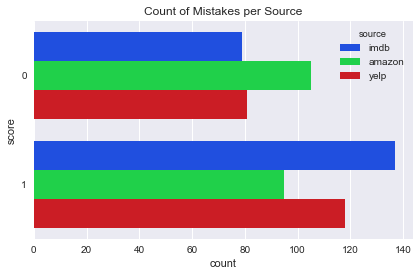

In [61]:
# plot the mistakes
ax = sns.countplot(y='score', 
                   hue='source', 
                   data=all_reviews[['source','score']][tfidf_mistakes], 
                   palette='bright')
plt.title('Count of Mistakes per Source')
save_fig("tfidf_default_top_30_features_mistakes")
plt.show()

In [62]:
# first, some of the mistakes on negative sentiment
display(all_reviews[['document','score', 'y_pred_def_tfidf']][tfidf_mistakes & neg_sentiment][:5])

,document,score,y_pred_def_tfidf
5,"The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.",0,1
25,This short film certainly pulls no punches.,0,1
26,Graphics is far from the best part of the game.,0,1
43,But it's just not funny.,0,1
45,"His co-stars don't fare much better, with people like Morgan Freeman, Jonah Hill, and Ed Helms just wasted.",0,1


In [63]:
# first, some of the mistakes on positive sentiment
display(all_reviews[['document','score', 'y_pred_def_tfidf']][tfidf_mistakes & ~neg_sentiment][:5])

,document,score,y_pred_def_tfidf
9,Loved the casting of Jimmy Buffet as the science teacher.,1,0
10,And those baby owls were adorable.,1,0
21,"In other words, the content level of this film is enough to easily fill a dozen other films.",1,0
22,How can anyone in their right mind ask for anything more from a movie than this?,1,0
31,Waste your money on this game.,1,0


In [64]:
# negative sentiment predicted negative w/ high confidence
display(all_reviews[['document','score', 'y_pred_prob_def_tfidf_0']][neg_sentiment & tfidf_neg_high][:5])

,document,score,y_pred_prob_def_tfidf_0
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,0.787071
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,0.813371
15,"It had some average acting from the main person, and it was a low budget as you clearly can see.",0,0.823876
47,"The only real effects work is the presence of all the animals, and the integration of those into the scenes is some of the worst and most obvious blue/green-screen work I've ever seen.",0,0.811076
68,This movie totally grates on my nerves.,0,0.771466


In [65]:
# and now positive sentiment predicted positive w/ high confidence|
display(all_reviews[['document','score', 'y_pred_prob_def_tfidf_1']][~neg_sentiment & tfidf_pos_high][:5])

,document,score,y_pred_prob_def_tfidf_1
12,The Songs Were The Best And The Muppets Were So Hilarious.,1,0.826916
13,It Was So Cool.,1,0.757791
18,"It's practically perfect in all of them Â– a true masterpiece in a sea of faux ""masterpieces.",1,0.810419
24,"Yes, this film does require a rather significant amount of puzzle-solving, but the pieces fit together to create a beautiful picture.",1,0.754059
28,It deserves strong love.,1,0.870978


In [66]:
# negative sentiment predicted negative with low confidence
display(all_reviews[['document','score', 'y_pred_prob_def_tfidf_0']][neg_sentiment & tfidf_neg_close][:5])

,document,score,y_pred_prob_def_tfidf_0
3,Very little music or anything to speak of.,0,0.587974
41,I wasn't the least bit interested.,0,0.569336
44,But even the talented Carrell can't save this.,0,0.569336
55,"But I recommend waiting for their future efforts, let this one go.",0,0.532918
65,One character is totally annoying with a voice that gives me the feeling of fingernails on a chalkboard.,0,0.556670


In [67]:
# positive sentiment predicted positive with low confidence
display(all_reviews[['document','score', 'y_pred_prob_def_tfidf_1']][~neg_sentiment & tfidf_pos_close][:5])

,document,score,y_pred_prob_def_tfidf_1
14,"This is a very ""right on case"" movie that delivers everything almost right in your face.",1,0.589321
16,"This review is long overdue, since I consider A Tale of Two Sisters to be the single greatest film ever made.",1,0.531547
29,It is an insane game.,1,0.528888
30,"There are massive levels, massive unlockable characters... it's just a massive game.",1,0.528888
36,This game rocks.,1,0.528888


#### The next question would be, what is the overlap between the two vector models?

If there is sufficient non-overlap, we could likely up the performance by utililizing both models.

Since we have written some boolean masks to examine the various qualities of predictions from both models, we can reuse these two see if this concept is worth pursuing. 

In [68]:
# create a boolean mask to examine when both models are wrong together
both_wrong = mistakes & tfidf_mistakes

In [69]:
# it looks like they are only both wrong 2.4 % of the time, so using both models seems promising
all_reviews[['document','score','y_pred_def_bow','y_pred_def_tfidf']][both_wrong].size / all_reviews.size

0.03781818181818182

In [70]:
# look at a few where both are wrong
all_reviews[['document','score','y_pred_def_bow','y_pred_def_tfidf']][both_wrong].head()

,document,score,y_pred_def_bow,y_pred_def_tfidf
25,This short film certainly pulls no punches.,0,1,1
26,Graphics is far from the best part of the game.,0,1,1
31,Waste your money on this game.,1,0,0
32,This is the kind of money that is wasted properly.,1,0,0
43,But it's just not funny.,0,1,1


In [71]:
# BoWs correct and TFIDF wrong
all_reviews[['document','score','y_pred_def_bow','y_pred_def_tfidf']][~mistakes & tfidf_mistakes].size / all_reviews.size 

0.036727272727272726

In [72]:
# BoWs correct and TFIDF wrong negative sentiment
all_reviews[['document','score','y_pred_prob_def_bow_0','y_pred_prob_def_tfidf_0']][neg_sentiment & ~mistakes & tfidf_mistakes].head()

,document,score,y_pred_prob_def_bow_0,y_pred_prob_def_tfidf_0
5,"The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.",0,0.551179,0.487936
69,"The performances are not improved by improvisation, because the actors now have twice as much to worry about: not only whether they're delivering the line well, but whether the line itself is any good.",0,0.697847,0.496021
146,The fish is badly made and some of its underwater shots are repeated a thousand times in the film.,0,0.568517,0.305388
159,"Yeah, the movie pretty much sucked.",0,0.527745,0.451675
176,"Artless camera-work endlessly presents us with the ugliest setting imaginable, i.e.",0,0.595283,0.408795


In [73]:
# BoWs correct and TFIDF wrong positive sentiment
all_reviews[['document','score','y_pred_prob_def_bow_1','y_pred_prob_def_tfidf_1']][~neg_sentiment & ~mistakes & tfidf_mistakes].head()

,document,score,y_pred_prob_def_bow_1,y_pred_prob_def_tfidf_1
9,Loved the casting of Jimmy Buffet as the science teacher.,1,0.545866,0.488714
10,And those baby owls were adorable.,1,0.721998,0.430664
21,"In other words, the content level of this film is enough to easily fill a dozen other films.",1,0.582090,0.467170
22,How can anyone in their right mind ask for anything more from a movie than this?,1,0.538962,0.466038
38,It's PURE BRILLIANCE.,1,0.658820,0.430664


In [74]:
# BoWs wrong and TFIDF correct
all_reviews[['document','score','y_pred_def_bow','y_pred_def_tfidf']][mistakes & ~tfidf_mistakes].size / all_reviews.size 

0.0044848484848484848

In [75]:
# BoWs wrong and TFIDF correct negative sentiment
all_reviews[['document','score','y_pred_prob_def_bow_0','y_pred_prob_def_tfidf_0']][neg_sentiment & mistakes & ~tfidf_mistakes].head()

,document,score,y_pred_prob_def_bow_0,y_pred_prob_def_tfidf_0
44,But even the talented Carrell can't save this.,0,0.328536,0.569336
221,There are the usual Hitchcock logic flaws.,0,0.410315,0.569336
576,"Lewis Black's considerable talent is wasted here too, as he is at his most incendiary when he is unrestrained, which the PG-13 rating certainly won't allow.",0,0.499384,0.501392
1090,"For a product that costs as much as this one does, I expect it to work far better and with greater ease than this thing does.",0,0.498048,0.544666
1135,The majority of the Logitech earbud headsets failed.,0,0.473153,0.510525


In [76]:
# BoWs wrong and TFIDF correct positive sentiment
all_reviews[['document','score','y_pred_prob_def_bow_1','y_pred_prob_def_tfidf_1']][~neg_sentiment & mistakes & ~tfidf_mistakes].head()

,document,score,y_pred_prob_def_bow_1,y_pred_prob_def_tfidf_1
57,Totally believable.,1,0.496350,0.509386
512,"For that, it's worth checking out.",1,0.480909,0.569136
619,Don't miss it.,1,0.440429,0.507631
621,"A mature, subtle script that suggests and occasionally brings into dramatic focus the underlying tensions is well served by perfect performances (apart from the odd inappropriate smiling that Keira Knightley is prone to, though perhaps under direction this time as the other characters themselves often mention it).",1,0.236738,0.540241
862,A film not easily forgotten.,1,0.495896,0.522082


In summary above, if we combined both models and utilized the highest confidence prediction, we would be accurate more than 93% of the time. This goes to demonstrate the improvements which can be achieved by combining two models if their strengths are complimentary (accurate in different areas and considering different aspects of the data).

### Visualize mistakes between models.
Correct predictions are white and mistake in black. This quick visualization assists in checking if the mistakes are similar and the amount of overlap between mistaken predictions. The idea is that the models make mistakes in different ways, at different times, and for different texts, then this could be used to our advantage when modeling. We could simply use the highest class prediction from the two models for predicting a label of unseen text. 

Saving figure Bag-of-Words vs. TFI-DF Positive Sentiment Predictions


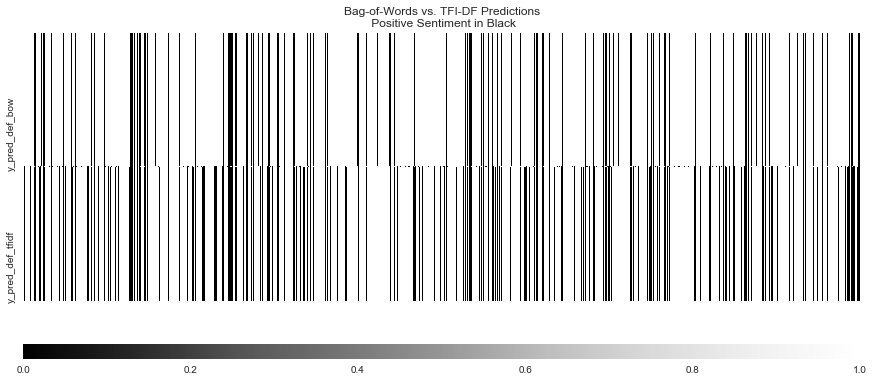

In [77]:
# incorrect predictions for positive sentiment are in black, as we're plotting 0's and 1's
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, 
                                gridspec_kw=grid_kws,
                                figsize=(15, 6))
ax = sns.heatmap(all_reviews[['y_pred_def_bow','y_pred_def_tfidf']][~neg_sentiment].T, 
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"}, cmap="Greys_r",
                 xticklabels=False # don't print the index labels on the x-axis
                )

ax.set_title('Bag-of-Words vs. TFI-DF Predictions\n Positive Sentiment in Black')
save_fig("Bag-of-Words vs. TFI-DF Positive Sentiment Predictions",tight_layout=False)
plt.show()

Saving figure Bag-of-Words vs. TFI-DF Negative Sentiment Predictions


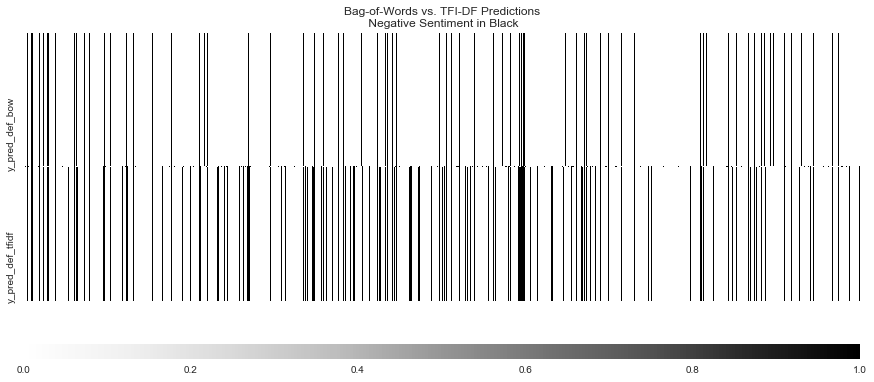

In [78]:
# incorrect predictions for negative sentiment are in black, as we're plotting 0's and 1's
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, 
                                gridspec_kw=grid_kws,
                                figsize=(15, 6))
ax = sns.heatmap(all_reviews[['y_pred_def_bow','y_pred_def_tfidf']][neg_sentiment].T, 
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"}, cmap="Greys",
                 xticklabels=False # don't print the index labels on the x-axis
                )

ax.set_title('Bag-of-Words vs. TFI-DF Predictions\n Negative Sentiment in Black')
save_fig("Bag-of-Words vs. TFI-DF Negative Sentiment Predictions",tight_layout=False)
plt.show()

## Feature Engineering - N-Grams
-----

### Can we improve TfidfVectorizer + Logistic Regression?
* Much of the processing in the baseline models were accomplished with __`sklearn`__ preprocessing within the classes __`CountVectorizer' & 'TfidfVectorizer`__. If the performance were likely a result of the preprocessing such as the following, more time could be spent doing this in NLTK (which I did but didn't produce much better results with the manual preprocessing):
  * **Noise Reduction** - removing non-relevant text to the context of the data (stop words, URLs/links, social media entities, punctuations and industry specific words, etc.)
  * **Lexicon Normalization** - feature engineering step by converting versions of a word into a lemma, effectively reducing dimensionality
    * stemming - rule-based, removing suffixes
    * lemmatization - obtaining root form of word, using a vocabulary (standard lexical dictionary for importance of words) and morphological analysis (word structure and grammar relations)

* Next I will look at increasing performance by using more than 1 n-gram (2 and 3)
* In summary, the initial TFIDF was the better performer.

In [79]:
# use sklearn's pipeline functionality
pipe = make_pipeline(TfidfVectorizer(sublinear_tf=True,
                                     min_df=5, 
                                     norm='l2', 
                                     encoding='latin-1', 
                                     max_features=10000,   # same as CountVectorizer
                                     stop_words="english"  # using sklearn's stopwords), 
                                     ), 
                     LogisticRegression()
                    )

# grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1,3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 1), 'logisticregression__C': 1}


__Observation:__ In general, the heatmap shows that there were slight gains for increasing model complexity. However, the best performing model was the one using only uni-grams and the LinearRegression arg C of 1. 

Saving figure logistic_regression_tfidf_gridsearch


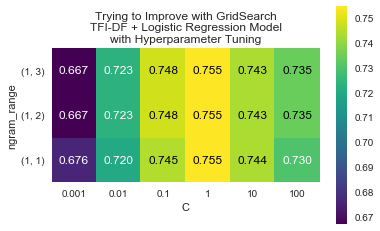

In [80]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heatmap
heatmap = h.heatmap(scores, 
                    xlabel="C", 
                    ylabel="ngram_range", 
                    cmap="viridis", 
                    fmt="%.3f",
                    xticklabels=param_grid['logisticregression__C'],
                    yticklabels=param_grid['tfidfvectorizer__ngram_range'])

plt.colorbar(heatmap)
plt.title('Trying to Improve with GridSearch\nTFI-DF + Logistic Regression Model\nwith Hyperparameter Tuning')
save_fig("logistic_regression_tfidf_gridsearch",tight_layout=False)
plt.show()

Saving figure logistic_regression_tfidf_gridsearch_best_estimator_top_30_features


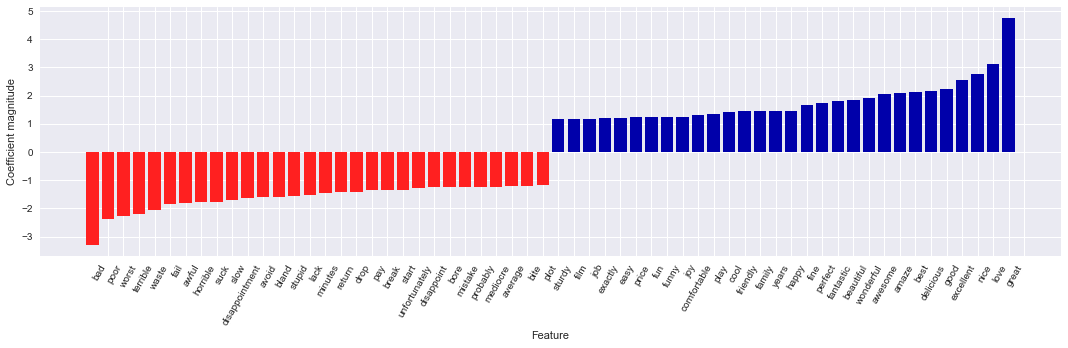

In [81]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
h.visualize_coefficients(coef, 
                         feature_names, 
                         n_top_features=30)

save_fig("logistic_regression_tfidf_gridsearch_best_estimator_top_30_features")

In [82]:
# save models (CountVectorizer and Logistic Regression)
save_model(grid.best_estimator_.named_steps['tfidfvectorizer'],'logistic_regression_w_tfidf_best_vect')
save_model(grid.best_estimator_,'logistic_regression_w_tfidf_best_model')

Saving model logistic_regression_w_tfidf_best_vect
Saving model logistic_regression_w_tfidf_best_model


## Feature Engineering - Hand-crafted
-----
  
* Sentence level features were created and will applied using helper functions that have been coded into the __`helpers.py`__ file. 


* Sentence level features are based upon the __*raw text*__. 
  * This is an attempt to regain information that may have been lost due to the processing of normalization, standardization and cleanup. 
  * This is accomlished by using a customer parser, demonstrated below.
  * Spoiler alert, this was not very successful.

In [83]:
# There are many types of tokenizers that could be used http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.regexp.RegexpTokenizer
# from github issues: https://stackoverflow.com/questions/36353125/nltk-regular-expression-tokenizer
text = 'That U.S.A. poster-print costs $12.40...'

pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''
custome_tokenizer_test = nltk.regexp_tokenize(text=text, pattern=pattern)
print(custome_tokenizer_test)
#['That', 'U.S.A.', 'poster-print', 'costs', '$12.40', '...']

['That', 'U.S.A.', 'poster-print', 'costs', '$12.40', '...']


## Custom Sentence Level Features
-----
* From the NLTK online book, using Python to represent the following is natural and intuitive:
  * __{*w* | *w* E V & *P*(*w*)}__
  * which means, "The set of all w such that w is an element of V (vocabulary) and w has property P."
  * This can be represented in Python using a list generator:
    * __`[w for w in V if p(w)]`__
    * this is the form used to produce the sentence level features


* Sentence Level Features include:
  * __`is_capitalized`__ - True/False if the sentence starts with a capitalized letter
  * __`all_caps_sent`__ - True/False if the sentence is all caps
  * __`all_caps_word_cnt`__ - Integer number of words in the sentence which are all caps
  * __`is_all_lower`__ - True/False if the sentene is all lower case
  * __`num_chars`__ - Integer number of characters in the sentence
  * __`word_count`__ - Integer number of total words (including duplicates) in the sentence
  * __`word_to_char_frac`__ - this is average number of characters per word per sentence 
  * __`vocab_size`__ - Integer number of unique words in the sentence
  * __`diversity_score`__ - Float number fraction of total words / total unique words (aka lexical diversity)
  * __`frac_unusual`__ - Float number fraction of unusual English words which are defined here as unusual or mispelled words using Word Corpus from the /user/share/dict/words Unix file used by spellcheckers
  * __`frac_non_stop_words`__ - Float number fraction of stop words in a sentence
  
  
* These sentence level features will be used as inputs to models.


* There are more that features I wanted to add, but did not have time:
  * more sentence level features:
    * if there are elipsis in the sentence
    * if there are hyphenated words
    * if there are abbreviations
    * if money is in the sentence ex. 'All that for \$15.00\!\!\!'
  * word level features

In [84]:
# example output of the customer sentence level features
h.engineered_sentence_features(custome_tokenizer_test) 

{'all_caps_sent': False,
 'all_caps_word_cnt': 1,
 'diversity_score': 1.0,
 'frac_non_stop_words': 0.8333333333333334,
 'frac_unusual': 0.16666666666666666,
 'is_all_lower': False,
 'is_capitalized': True,
 'num_chars': 36,
 'vocab_size': 6,
 'word_count': 6,
 'word_to_char_frac': 6.0}

In [85]:
# view this in a transposed dataframe format
pd.DataFrame.from_dict(h.engineered_sentence_features(custome_tokenizer_test), 
                       orient='index')

,0
all_caps_sent,False
vocab_size,6
is_capitalized,True
word_to_char_frac,6
frac_non_stop_words,0.833333
num_chars,36
is_all_lower,False
diversity_score,1
word_count,6
frac_unusual,0.166667


## Preprocess DataFrame for ML Algos
-----
* apply custom_tokenizer
* apply engineered_sentence_features

In [86]:
# apply custom tokenizer to the dataframe with raw text
custom_tokenizer = RegexpTokenizer(pattern)

all_reviews["custom_tokens"] = all_reviews["document"].apply(custom_tokenizer.tokenize)

# review sample output
all_reviews[['document','custom_tokens']].head()

,document,custom_tokens
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.","[A, very, ,, very, ,, very, slow-moving, ,, aimless, movie, about, a, distressed, ,, drifting, young, man, .]"
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.","[Not, sure, who, was, more, lost, -, the, flat, characters, or, the, audience, ,, nearly, half, of, whom, walked, out, .]"
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.","[Attempting, artiness, with, black, white, and, clever, camera, angles, ,, the, movie, disappointed, -, became, even, more, ridiculous, -, as, the, acting, was, poor, and, the, plot, and, lines, almost, non-existent, .]"
3,Very little music or anything to speak of.,"[Very, little, music, or, anything, to, speak, of, .]"
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,"[The, best, scene, in, the, movie, was, when, Gerardo, is, trying, to, find, a, song, that, keeps, running, through, his, head, .]"


__Inspect the Custom Tokens__
  * The majority of the sentences are within the inner quartile range between 6 and 19 with the median near 12.
  * Even though there are some long documents, the majority are within a similar range.
  * Amazon and Yelp are more similar thah iMDB, which tends to have lenthier documents and appears to have more outliers.

In [87]:
all_words = [word for tokens in all_reviews["custom_tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in all_reviews["custom_tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

41659 words total, with a vocabulary size of 6022
Max sentence length is 81


Saving figure sentence_length_distribution


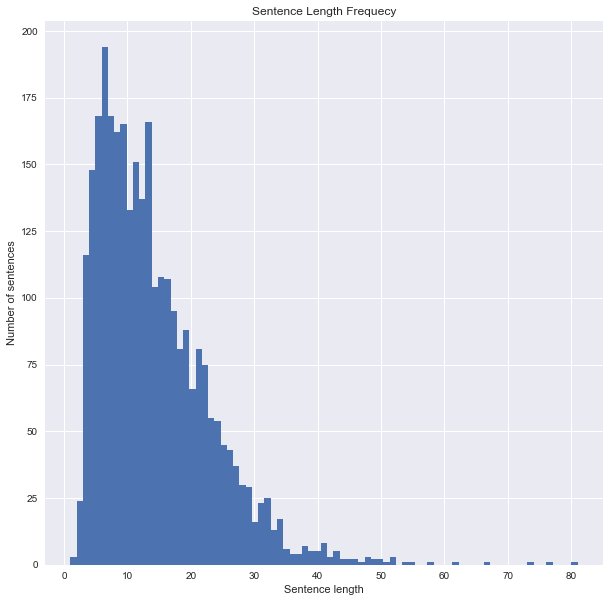

In [88]:
# this is a general view of sentence length, 
# including positive and negative sentement
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Sentence Length Frequecy')
plt.hist(sentence_lengths,bins=81)
save_fig("sentence_length_distribution",tight_layout=False)
plt.show()

Saving figure sentence_length_boxplot


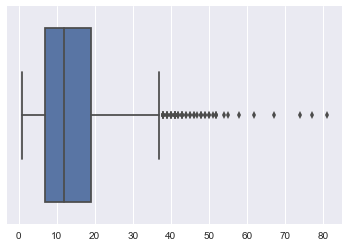

In [89]:
# sentence length by word count
# boxplot showing the median near 12, and the upper and lower quartiles
sns.boxplot(sentence_lengths)
save_fig("sentence_length_boxplot",tight_layout=False)

Saving figure sentence_length_boxplots_per_source


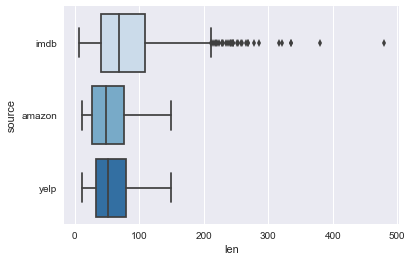

In [90]:
# breakdown of the sentence lengths by character count by source
sns.boxplot(y=all_reviews['source'], x=all_reviews['len'], palette='Blues')
save_fig("sentence_length_boxplots_per_source",tight_layout=False)

In [91]:
# since the apply functions are slow, use the data saved from previous run
if DATA_PATH:
    df_engineered_sentence_features = pd.read_csv(os.path.join(DATA_PATH, r'engineered_sentence_features.csv'), 
                                                  index_col=0)
    
else:
    # WARNING - this part is slow
    # apply custom features to the data
    all_reviews['engineered_sentence_features'] = all_reviews['custom_tokens'].apply(h.engineered_sentence_features)
    
    # flatten the engineered_sentence_features into a dataframe
    df_engineered_sentence_features = all_reviews['engineered_sentence_features'].apply(pd.Series)
    
    #save off the data to save time for reviewer
    df_engineered_sentence_features.to_csv(os.path.join(DATA_PATH, r'engineered_sentence_features.csv'))

# inspect engineered features data
display(df_engineered_sentence_features.info())
display(df_engineered_sentence_features.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 11 columns):
all_caps_sent          3000 non-null bool
all_caps_word_cnt      3000 non-null int64
diversity_score        3000 non-null float64
frac_non_stop_words    3000 non-null float64
frac_unusual           3000 non-null float64
is_all_lower           3000 non-null bool
is_capitalized         3000 non-null bool
num_chars              3000 non-null int64
vocab_size             3000 non-null int64
word_count             3000 non-null int64
word_to_char_frac      3000 non-null float64
dtypes: bool(3), float64(4), int64(4)
memory usage: 219.7 KB


None

,all_caps_sent,all_caps_word_cnt,diversity_score,frac_non_stop_words,frac_unusual,is_all_lower,is_capitalized,num_chars,vocab_size,word_count,word_to_char_frac
0,False,1,1.384615,0.666667,0.000000,False,True,73,12,18,4.055556
1,False,0,1.050000,0.523810,0.095238,False,True,79,20,21,3.761905
2,False,0,1.185185,0.687500,0.093750,False,True,155,27,32,4.843750
3,False,0,1.000000,0.555556,0.000000,False,True,35,9,9,3.888889
4,False,0,1.000000,0.500000,0.090909,False,True,86,21,22,3.909091


In [92]:
reviews_features = all_reviews.merge(df_engineered_sentence_features, how='outer',left_index=True, right_index=True)
reviews_features.columns.tolist()
cols_keep = [ 'document',
 'score',
 'source',
 'all_caps_sent',
 'all_caps_word_cnt',
 'diversity_score',
 'frac_non_stop_words',
 'frac_unusual',
 'is_all_lower',
 'is_capitalized',
 'num_chars',
 'vocab_size',
 'word_count',
 'word_to_char_frac']
reviews_features[cols_keep].head()

,document,score,source,all_caps_sent,all_caps_word_cnt,diversity_score,frac_non_stop_words,frac_unusual,is_all_lower,is_capitalized,num_chars,vocab_size,word_count,word_to_char_frac
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,imdb,False,1,1.384615,0.666667,0.000000,False,True,73,12,18,4.055556
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,imdb,False,0,1.050000,0.523810,0.095238,False,True,79,20,21,3.761905
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,imdb,False,0,1.185185,0.687500,0.093750,False,True,155,27,32,4.843750
3,Very little music or anything to speak of.,0,imdb,False,0,1.000000,0.555556,0.000000,False,True,35,9,9,3.888889
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,imdb,False,0,1.000000,0.500000,0.090909,False,True,86,21,22,3.909091


In [93]:
# some quick stats on hand-engineered features
reviews_features[cols_keep].describe().T

,count,mean,std,min,25%,50%,75%,max
score,3000.0,0.500000,0.500083,0.0,0.0,0.500000,1.000000,1.000000
all_caps_word_cnt,3000.0,0.474333,0.875365,0.0,0.0,0.000000,1.000000,15.000000
diversity_score,3000.0,1.051270,0.084383,1.0,1.0,1.000000,1.090909,2.000000
frac_non_stop_words,3000.0,0.596731,0.152479,0.2,0.5,0.571429,0.666667,1.000000
frac_unusual,3000.0,0.076202,0.087251,0.0,0.0,0.062500,0.125000,0.666667
num_chars,3000.0,53.570333,36.295530,4.0,27.0,46.000000,72.000000,407.000000
vocab_size,3000.0,12.803667,7.514116,1.0,7.0,11.000000,17.000000,59.000000
word_count,3000.0,13.886333,8.960181,1.0,7.0,12.000000,19.000000,81.000000
word_to_char_frac,3000.0,3.901527,0.801059,1.8,3.4,3.833333,4.316388,11.000000


## reviewing samples of null vals w/ their rows
* no null values in the engineered features

In [94]:
print('missing\tcolumn name')
for col in df_engineered_sentence_features.columns:
    if df_engineered_sentence_features[col].isnull().sum() > 0:
        print('{}\t{}'.format(df_engineered_sentence_features[col].isnull().sum(), col))

missing	column name


## Categorical Engineered Features
* two are rare, one is skewed

In [95]:
# map the boolean columns to [0,1]
bool_map = {True:1, False:0}
df_engineered_sentence_features['all_caps_sent'] = df_engineered_sentence_features['all_caps_sent'].map(bool_map)
df_engineered_sentence_features['is_all_lower'] = df_engineered_sentence_features['is_all_lower'].map(bool_map)
df_engineered_sentence_features['is_capitalized'] = df_engineered_sentence_features['is_capitalized'].map(bool_map)

In [96]:
df_engineered_sentence_features.head()

,all_caps_sent,all_caps_word_cnt,diversity_score,frac_non_stop_words,frac_unusual,is_all_lower,is_capitalized,num_chars,vocab_size,word_count,word_to_char_frac
0,0,1,1.384615,0.666667,0.000000,0,1,73,12,18,4.055556
1,0,0,1.050000,0.523810,0.095238,0,1,79,20,21,3.761905
2,0,0,1.185185,0.687500,0.093750,0,1,155,27,32,4.843750
3,0,0,1.000000,0.555556,0.000000,0,1,35,9,9,3.888889
4,0,0,1.000000,0.500000,0.090909,0,1,86,21,22,3.909091


## Visualize the Numerical Engineered Features
* only one of these features looks normally distributed
* the features will need to be standardized to keep the model from favoring higher valued features

['all_caps_sent', 'all_caps_word_cnt', 'diversity_score', 'frac_non_stop_words', 'frac_unusual', 'is_all_lower', 'is_capitalized', 'num_chars', 'vocab_size', 'word_count', 'word_to_char_frac']


C:\Anaconda3\envs\tf-nlp-gpu\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Saving figure feature_engineering_original_distributions


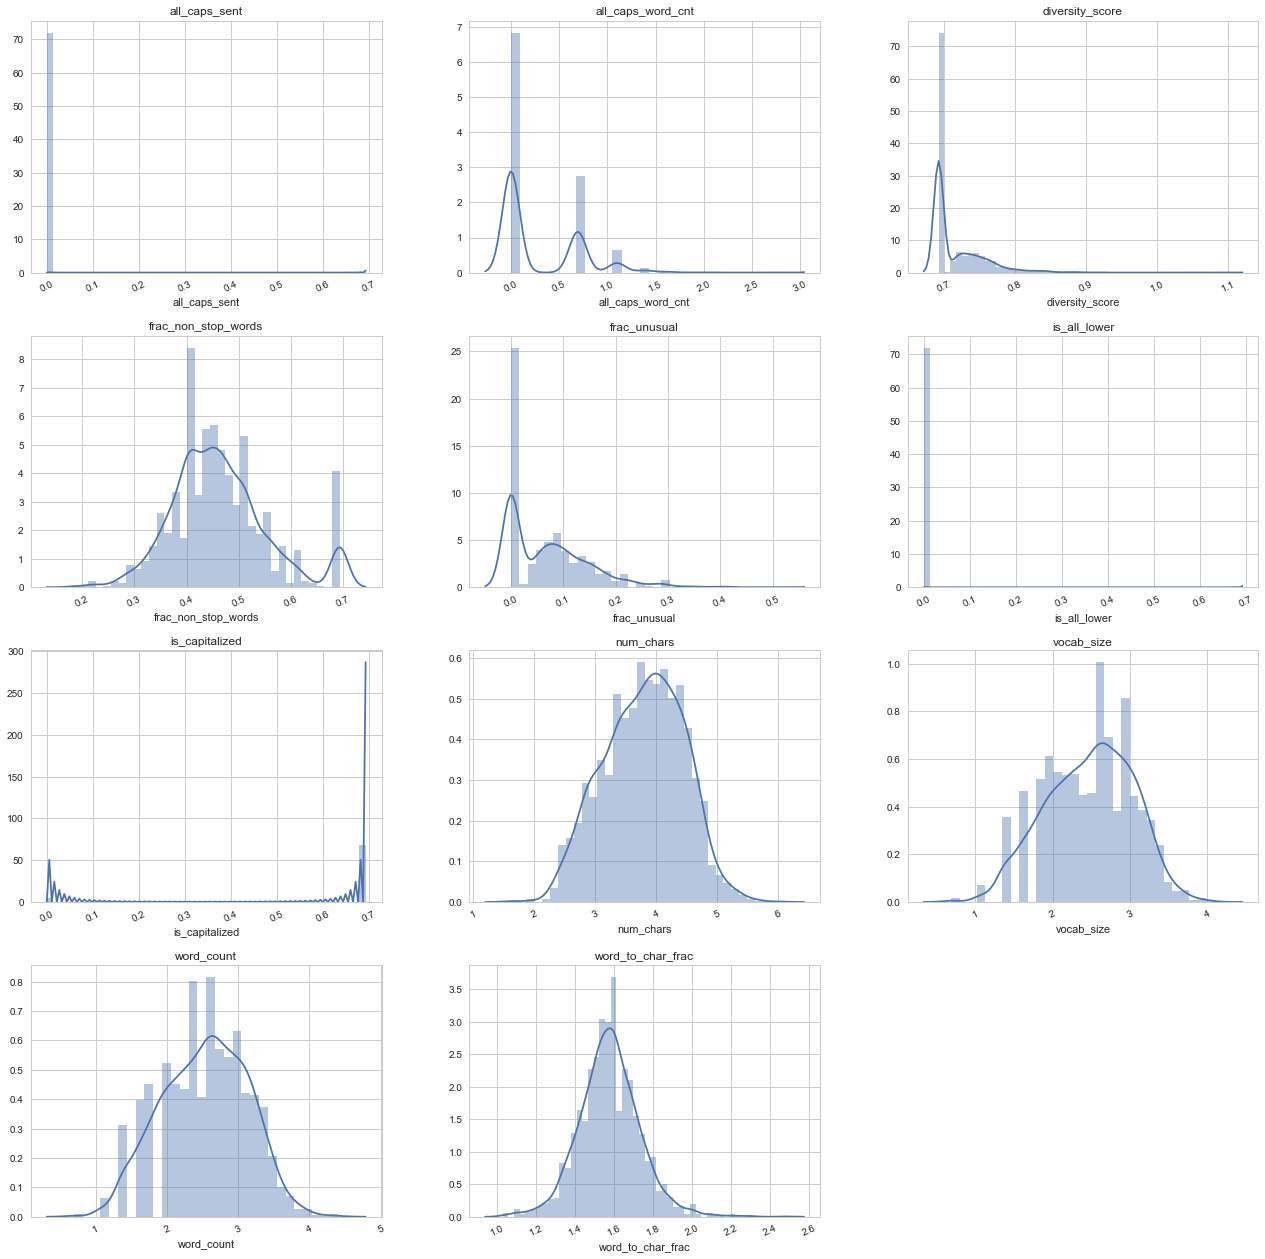

In [97]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

# numerical
num_cols = df_engineered_sentence_features.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)
plot_distribution(np.log(df_engineered_sentence_features[num_cols].dropna() + 1), 
                  cols=3, 
                  width=22, 
                  height=2*df_engineered_sentence_features[num_cols].shape[1], 
                  hspace=0.25, 
                  wspace=0.25)

save_fig("feature_engineering_original_distributions",tight_layout=False)

In [98]:
df_engineered_sentence_features[num_cols].shape[1]

11

## Pipeline - Preprocess the Engineered Features
-----
* create a dataframe selector 
* cleanup and create features

In [99]:
# transformer to just select a subset of the Pandas DataFrame columns:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MaxAbsScaler


# get list of number cols
num_attribs = df_engineered_sentence_features.select_dtypes(include=[np.number]).columns.tolist()
#cat_attribs = ['']

# pipeline for processing numerical attribs
# fill missining w/ median
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                        ('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), 
                        #('std_scaler', StandardScaler()),
                         ('max_abs_scaler', MaxAbsScaler()),
                         ('polynomials', PolynomialFeatures(degree=2))
                       ])

# pipeline for processing categorical attribs
#cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)), 
#                        ('cat_encoder', CategoricalEncoder(encoding='onehot-dense')),
#                       ])

# full pre-processing pipeline
#full_pipeline = FeatureUnion(transformer_list=[
#        ('num_pipeline', num_pipeline),
#        ('cat_pipeline', cat_pipeline),
#    ])

#dataset_preped = full_pipeline.fit_transform(dataset)

dataset_prepped = num_pipeline.fit_transform(reviews_features)

C:\Anaconda3\envs\tf-nlp-gpu\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda3\envs\tf-nlp-gpu\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Anaconda3\envs\tf-nlp-gpu\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Saving figure feature_engineering_transformed_distributions


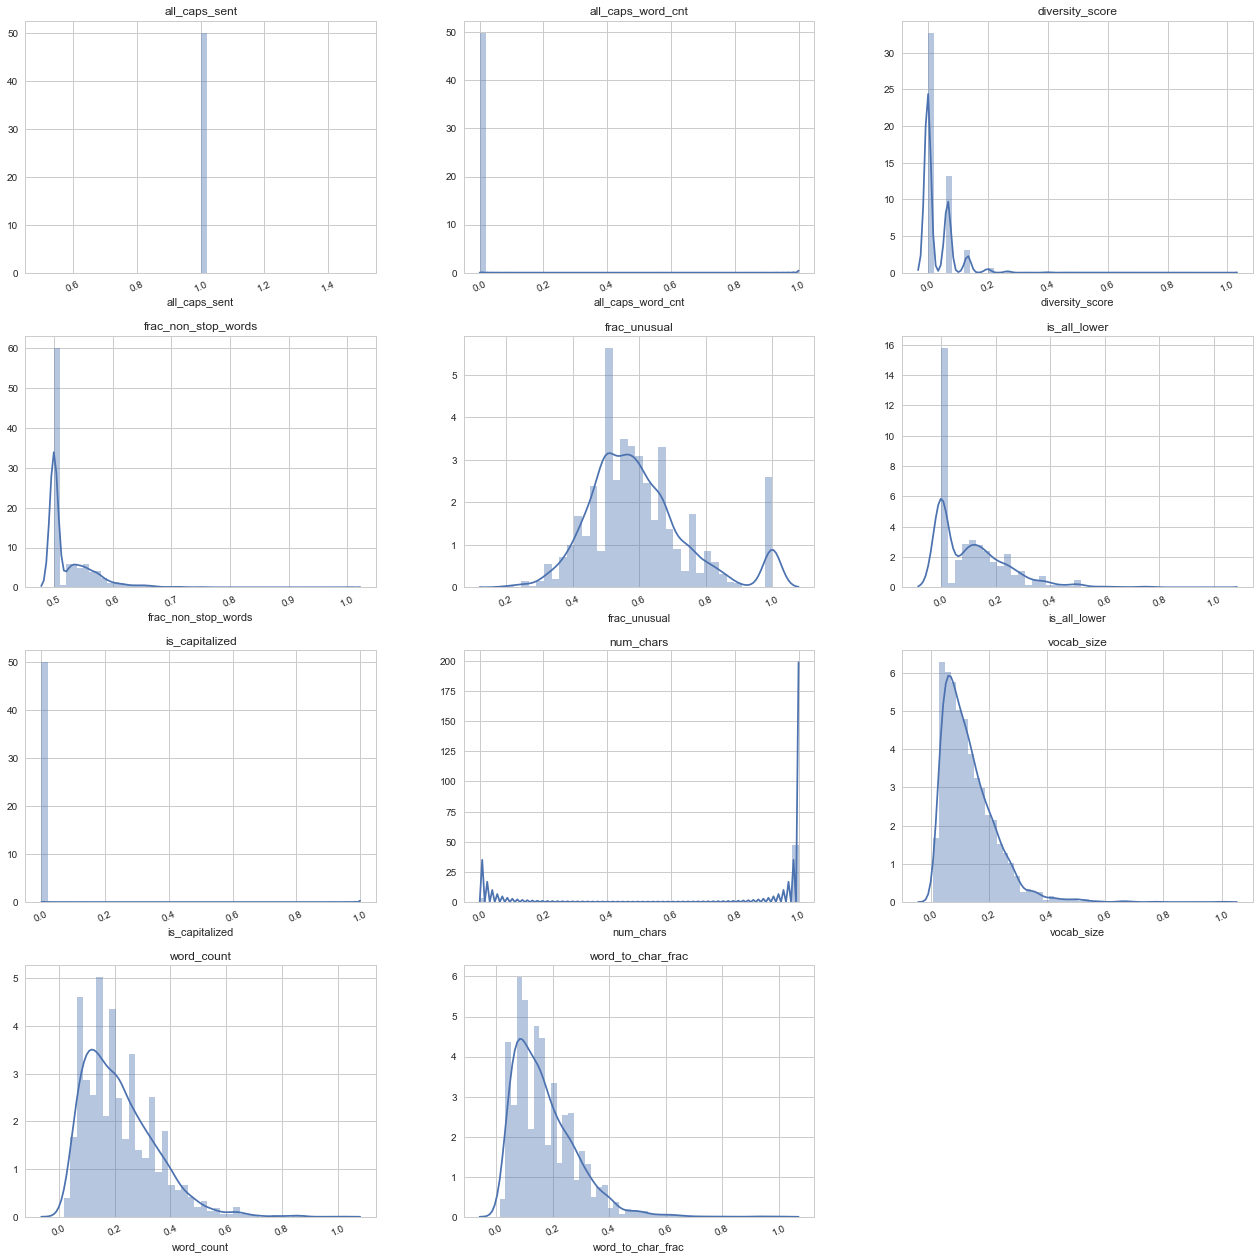

In [100]:
# only plotting the non-ploynimial, original features that are transformed
plot_distribution(pd.DataFrame(dataset_prepped[:,:len(num_attribs)], columns=num_attribs), 
                  cols=3, 
                  width=22, 
                  height=2*df_engineered_sentence_features[num_cols].shape[1], 
                  hspace=0.25, 
                  wspace=0.25)

save_fig("feature_engineering_transformed_distributions",tight_layout=False)

In [101]:
# split engineered features into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_prepped, 
                                                    reviews_features['score'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 2400 samples.
Testing set has 600 samples.


## Compare Various Models with the Engineered Features
-----
* this part was run in another notebook (python 2)
* utized code learned in the class
* examining more than just accuracy
  * time to train and predict
  * results with varied data sampling
  * using f1 score

In summary, these appear to not add much value and are just above random.

In [102]:
IMAGES_PATH

'.\\images'

In [103]:
## TODO read and display images
engineered_features = os.path.join(IMAGES_PATH,'model_results*_engineered_features.png')
images = glob(engineered_features)
images

['.\\images\\model_results1_engineered_features.png',
 '.\\images\\model_results2_engineered_features.png']

* GaussianNB trained on 24, 240, and 2400 samples.
* LinearSVC trained on 24, 240, and 2400 samples.
* LinearDiscriminantAnalysis trained on 24, 240, and on 2400 samples.

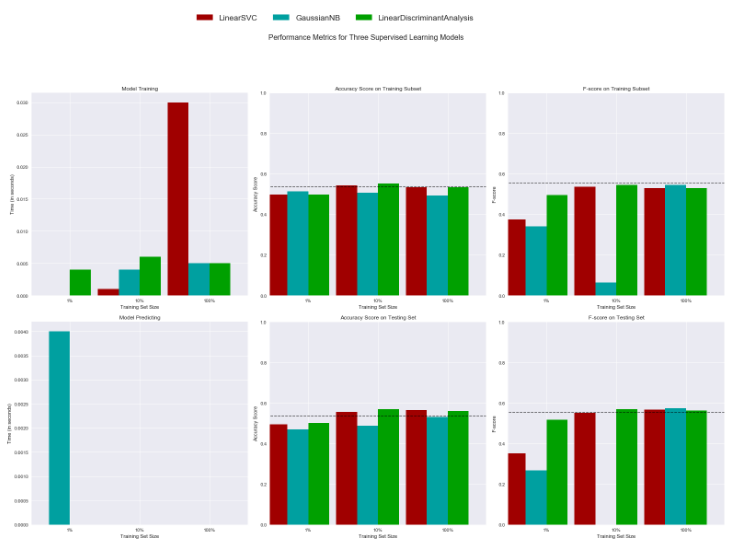

In [104]:
Image(filename = images[0], width=1000, height=1000)

* KNeighborsClassifier trained on 24, 240, and 2400 samples.
* MultinomialNB trained on 24, 240, and 2400 samples.
* RandomForestClassifier trained on 24, 240, and on 2400 samples.

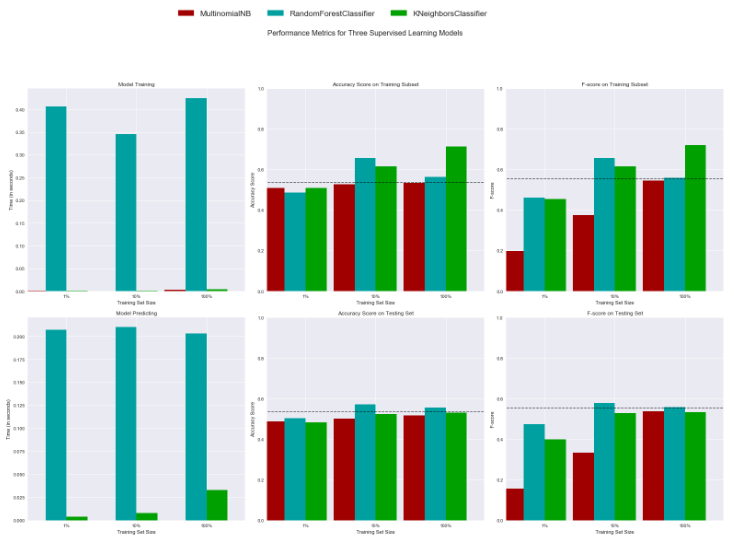

In [105]:
Image(filename = images[1], width=1000, height=1000)

## Using [Gensim + Google's word2vec w/ 300 vectors](https://radimrehurek.com/gensim/models/word2vec.html)
-----
* the idea is that __`CountVectorizer`__ & __`TfdifVectorizer`__ capture the counts or a scaled vector of inverse document frequency which is essentially signalling on the presence of a word. 
* without a large training dataset, a lot of semantic meaning can be missed
* give model data representation where words like __*greatest*__ and __*best*__ have similar vectors while words like __*best*__ and __*worst*__ have vectors that are further
* we will represent individual words and sentences as vectors, then adding the vectors together as well as taking the average
* word vectors can be visualized by reducing dimensionality with PCS, then projecting them onto 2D space (this loses information but the regular structure is still often observable)
* below will use __`gensim`__ and __`word2vec`__ to capture semantic meaning by way of distance metrcis
* create the tokens from the custom tokenizer and normalization, gensim expects a list of tokens for a sentence/document

### About Google's word2vec
* the word2vec model trained by Google on the Google News dataset, 
* on about 100 billion words
* contains 3,000,000 unique phrases built with layer size of 300
* Note that the similarities were trained on a news dataset, and that Google did very little preprocessing there. So the phrases are case sensitive: watch out! Especially with proper nouns. There are typos and spelling errors as well.

### Cool Ideas/Research Papers on Word2Vec
* [Applying word2vec to Recommenders and Advertising](http://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/)
  * using word2vec on recommender systems like Airbnb
  * “Researchers from the Web Search, E-commerce and Marketplace domains have realized that just like one can train word embeddings by treating a sequence of words in a sentence as context, the same can be done for training embeddings of user actions by treating sequence of user actions as context.” - Mihajlo Grbovic, Airbnb
* [Using Word2vec for Music Recommendations](https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484)
* [Document Classification by Inversion of
Distributed Language Representations](https://arxiv.org/pdf/1504.07295.pdf)
  * this seems like a logical extension of count vectors and TFIDF.
* potential use of [word2vec w/ SpaCy](https://stackoverflow.com/questions/42094180/spacy-how-to-load-google-news-word2vec-vectors)
* [Transform Anything into a Vector - entity2vec](https://blog.insightdatascience.com/entity2vec-dad368c5b830)

In [106]:
# load the model, path to the word2vec embeddings
# should take about 1 min.
word2vec = gensim.models\
                 .KeyedVectors\
                 .load_word2vec_format(os.path.join(DATA_PATH,'GoogleNews-vectors-negative300.bin.gz'), 
                                       binary=True)

In [107]:
# playing with some of the functionality of word2vec
word2vec.doesnt_match("car bus truck ship".split())

'ship'

In [108]:
# try this on a particular sentence in the data
print('DOCUMENT\n')
print(all_reviews["document"][1])
print('\nTOKENS:\n')
print(all_reviews["tokens"][1])
print("\nThe word *{}* doesn't match.".format(word2vec.doesnt_match(all_reviews["tokens"][1])))

DOCUMENT

Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  

TOKENS:

['sure', 'lose', 'flat', 'character', 'audience', 'nearly', 'half', 'walk']

The word *audience* doesn't match.


In [109]:
word2vec.most_similar("amazing")

[('incredible', 0.9054002165794373),
 ('awesome', 0.8282864689826965),
 ('unbelievable', 0.820126473903656),
 ('fantastic', 0.778986930847168),
 ('phenomenal', 0.7642049193382263),
 ('astounding', 0.7347069382667542),
 ('wonderful', 0.7263176441192627),
 ('unbelieveable', 0.7165082097053528),
 ('remarkable', 0.7095626592636108),
 ('marvelous', 0.7015584111213684)]

In [110]:
word2vec.most_similar("boring")

[('dull', 0.7369751930236816),
 ('uninteresting', 0.7017821669578552),
 ('monotonous', 0.6794682145118713),
 ('bored', 0.6460508108139038),
 ('bland', 0.6317018866539001),
 ('tedious', 0.6252800822257996),
 ('unexciting', 0.6183233261108398),
 ('tiresome', 0.6091724634170532),
 ('mind_numbingly_boring', 0.6050267815589905),
 ('dreadfully_boring', 0.5910888314247131)]

In [111]:
word2vec.most_similar("really")

[('obviously', 0.7450399398803711),
 ('definitely', 0.7389695048332214),
 ('think', 0.7071926593780518),
 ('pretty', 0.696144700050354),
 ('Really', 0.6944487690925598),
 ('kinda', 0.6779208779335022),
 ('just', 0.6747442483901978),
 ('kind', 0.669611930847168),
 ('everybody', 0.663794755935669),
 ('so', 0.6636056303977966)]

In [112]:
# it looks like distance and similarity are very 'similar'
print('distance =',word2vec.distance(w1='unpleasant',w2='horrible'))
print('similarity =',word2vec.similarity(w1='unpleasant',w2='horrible'))

distance = 0.492344635727
similarity = 0.507655364273


In [113]:
word2vec.similarity('woman','man')

0.76640122309953518

In [114]:
# can do some math like woman + king - man
word2vec.most_similar(positive=['woman', 'king'], 
                      negative=['man'])#[0]

[('queen', 0.711819589138031),
 ('monarch', 0.6189677119255066),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499463081359863),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181135535240173),
 ('sultan', 0.5098592042922974),
 ('monarchy', 0.5087411999702454)]

In [115]:
# this is a different similarity and a link to the differences if used to get analogies
# https://stackoverflow.com/questions/31524898/gensim-word2vec-semantic-similarity
word2vec.most_similar(positive=['human'], negative=['animal'])#[0]

[('mankind', 0.3513610363006592),
 ('humankind', 0.34724828600883484),
 ('humanity', 0.34104374051094055),
 ('macrocosm', 0.3094218969345093),
 ('intelligence_HUMINT', 0.3089752793312073),
 ('corporeal', 0.30723682045936584),
 ('executive_Nancy_Tullos', 0.30654528737068176),
 ('multiplicities', 0.30226701498031616),
 ('Christine_Gaugler_head', 0.30204129219055176),
 ('perfections', 0.3017750084400177)]

In [116]:
word2vec.most_similar(positive = ['he','male','mr'],
                      negative = ['mrs','female'])

[('him', 0.48067164421081543),
 ('himself', 0.4521825611591339),
 ('his', 0.44272810220718384),
 ('guy', 0.43564876914024353),
 ("he'sa", 0.42242512106895447),
 ('nobody', 0.4151723086833954),
 ('He', 0.41002699732780457),
 ('absolved_von_Oelhoffen', 0.4090070426464081),
 ('worry_Buddy_Shadid', 0.4064016342163086),
 ('anybody', 0.40464794635772705)]

In [117]:
word2vec.most_similar("United_States")

[('Unites_States', 0.7877250909805298),
 ('Untied_States', 0.7541372179985046),
 ('United_Sates', 0.7400727272033691),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404394507408142),
 ('America', 0.6178411245346069),
 ('UnitedStates', 0.6167311072349548),
 ('Europe', 0.6132987141609192),
 ('countries', 0.6044802665710449),
 ('Canada', 0.6019065380096436)]

In [118]:
# raw NumPy output vector of a word
word2vec['bad']

array([ 0.06298828,  0.12451172,  0.11328125,  0.07324219,  0.03881836,
        0.07910156,  0.05078125,  0.171875  ,  0.09619141,  0.22070312,
       -0.04150391, -0.09277344, -0.02209473,  0.14746094, -0.21582031,
        0.15234375,  0.19238281, -0.05078125, -0.11181641, -0.3203125 ,
        0.00506592,  0.15332031, -0.02563477, -0.0234375 ,  0.36328125,
        0.20605469,  0.04760742, -0.02624512,  0.09033203,  0.00457764,
       -0.15332031,  0.06591797,  0.3515625 , -0.12451172,  0.03015137,
        0.16210938,  0.00242615, -0.02282715,  0.02978516,  0.00531006,
        0.25976562, -0.22460938,  0.29492188, -0.18066406,  0.07910156,
        0.02282715,  0.12109375, -0.17382812, -0.03735352, -0.06933594,
       -0.21972656,  0.1875    , -0.03320312, -0.06225586, -0.04492188,
        0.11621094, -0.23339844, -0.11669922,  0.09814453, -0.11962891,
        0.13964844,  0.28710938, -0.26953125, -0.05493164,  0.03112793,
       -0.05029297,  0.1328125 , -0.01831055, -0.37695312, -0.06

In [119]:
# taking the average vector for the document
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    '''dataframe column to list
    '''
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, all_reviews, generate_missing=False):
    embeddings = all_reviews['tokens'].apply(lambda x: get_average_word2vec(x, 
                                                                            vectors, 
                                                                            generate_missing=generate_missing)
                                                )
    return list(embeddings)

## Use word2vec - average the vectors of each sentence to be used by ML model
-----
* this produced a small improvement over the other embedding models (CountVectorizer, TfidfVectorizer, and the word2vec w/o generating missing vectors)

In [120]:
# create the embeddings using gensim
word2vec_embeddings = get_word2vec_embeddings(word2vec,
                                              all_reviews)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(word2vec_embeddings, 
                                                                                        all_reviews['score'].tolist(), 
                                                                                        test_size=0.2, 
                                                                                        random_state=40)

In [121]:
# can use word2vec embeddings instead of BOWs or TFIDF embeddings
word2vec_embeddings[0]

array([ 0.15039062,  0.07678223, -0.14038086,  0.09433419, -0.09378488,
       -0.00748989, -0.06120954, -0.01146589,  0.03111049,  0.0479551 ,
        0.01242501, -0.06827218, -0.04645647,  0.05245972, -0.09214565,
       -0.02441406, -0.0083531 ,  0.1418457 , -0.03932408, -0.14069475,
        0.05077689,  0.10760716, -0.04253278, -0.01567732,  0.09204102,
       -0.03367833, -0.02232143,  0.16289411,  0.17257254, -0.0313064 ,
       -0.08163888, -0.08227539, -0.03844779, -0.09251186, -0.01729911,
        0.04684012,  0.06233433, -0.06476702,  0.014631  ,  0.07547433,
        0.09066336, -0.0471889 ,  0.14263916, -0.09595598, -0.04129464,
       -0.03469413, -0.06209019, -0.01390294,  0.06546456, -0.03295462,
       -0.04160854,  0.02985491,  0.00892857, -0.02098519,  0.09810965,
       -0.09470476,  0.05278669, -0.13272531, -0.0750776 , -0.05333437,
        0.04160854,  0.15994699, -0.02922712, -0.10487584, -0.04286412,
       -0.02238028, -0.07751465,  0.01724679, -0.01904297, -0.05

In [122]:
lr_clf_w2v = LogisticRegression(C=1, #30.0,
                                class_weight='balanced', 
                                solver='newton-cg', 
                                multi_class='multinomial', 
                                random_state=42)

lr_clf_w2v.fit(X_train_word2vec, y_train_word2vec)
# predict the test set with the trained word2vec + Logistic Regression model
y_predicted_word2vec = lr_clf_w2v.predict(X_test_word2vec)

In [123]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = h.get_metrics(y_test_word2vec, 
                                                                                    y_predicted_word2vec)

print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, 
                                                                       precision_word2vec, 
                                                                       recall_word2vec, 
                                                                       f1_word2vec))

accuracy = 0.817, precision = 0.819, recall = 0.817, f1 = 0.817


## Let's plot the LogisticRegression 
-----
* use the dataset to see how labeled as [0,1]
* The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) shows the random (red-dashed) classifier line which is like our naive classifier guessing and the solid blue line which is the ROC curve. This shows the diagnostic ability of the binary classfier model as its discrimination threshold varies.

For this particular model, this chart helps assess the tradeoffs between the two Positive Rates. The actual selection would depend upon the application. For example, one group might accept more false positives in order to catch more true negatives (a more inclusive strategy). While, on the other hand, another business group might only be concerned with the probability of identifying the target as being as exact/confident/high probability as one can be given the data (higher precision) - taking only a few true positive and very few false positive.

Saving figure logistic_regression_word2vec_ROC_curve


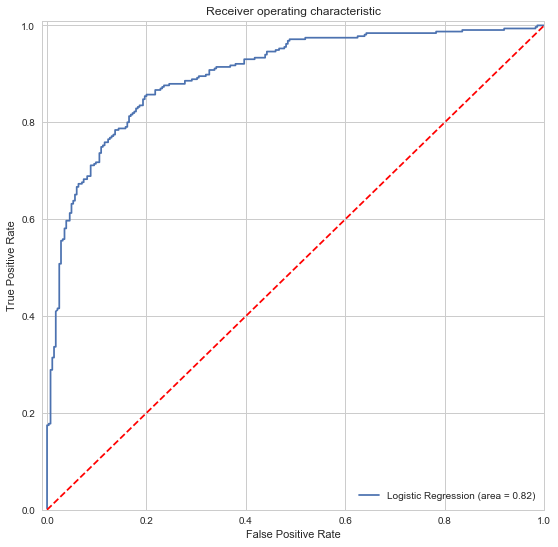

In [124]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test_word2vec, lr_clf_w2v.predict(X_test_word2vec))
fpr, tpr, thresholds = roc_curve(y_test_word2vec, lr_clf_w2v.predict_proba(X_test_word2vec)[:,1])
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
save_fig("logistic_regression_word2vec_ROC_curve",tight_layout=False)
plt.show()

In [125]:
# review misclassified predictions
index = 0
misclassified_index = []
for label, predict in zip(y_test_word2vec, lr_clf_w2v.predict(X_test_word2vec)):
    if label != predict:
        misclassified_index.append(index)

In [126]:
df_pred_test = all_reviews[['document','score']].merge(pd.DataFrame(lr_clf_w2v.predict_proba(X_test_word2vec)), 
                                                       how='right',
                                                       right_index=True,
                                                       left_index=True)

df_pred_test.head()

,document,score,0,1
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,0.318001,0.681999
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,0.659459,0.340541
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,0.133475,0.866525
3,Very little music or anything to speak of.,0,0.559590,0.440410
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,0.296151,0.703849


In [127]:
df_pred_test.rename(columns={0:'0', 1:'1'}, inplace=True)

Saving figure logistic_regression_tfidf_gridsearch


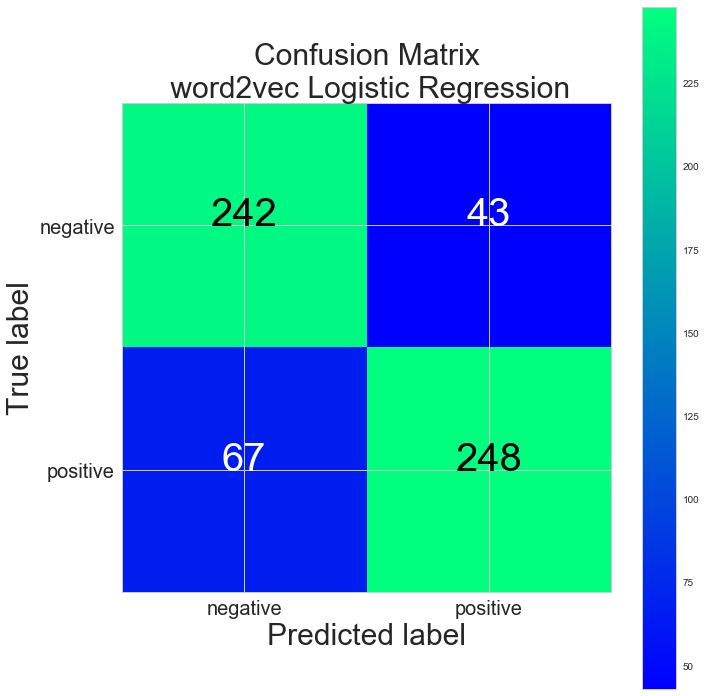

In [128]:
# create a confusion matrix
conf_matrix = h.confusion_matrix(y_test_word2vec, 
                                 y_predicted_word2vec)

# plot the confusion matrix
fig = plt.figure(figsize=(10,10))
plot = h.plot_confusion_matrix(conf_matrix,
                               classes=['negative','positive'], 
                               normalize=False, 
                               title='Confusion Matrix\n word2vec Logistic Regression')

save_fig("logistic_regression_tfidf_gridsearch",tight_layout=False)
plt.show()

In [129]:
# add the predicted labels and their probabilities to the all_reviews dataframe for model comparison
y_pred_w2v = lr_clf_w2v.predict(word2vec_embeddings)
y_pred_prob_w2v = lr_clf_w2v.predict_proba(word2vec_embeddings)
all_reviews['y_pred_w2v'] = y_pred_w2v
all_reviews['y_pred_prob_w2v0'] = y_pred_prob_w2v[:,0]
all_reviews['y_pred_prob_w2v1'] = y_pred_prob_w2v[:,1]

### Investigate mistakes, high and low confidence predictions from word2vec + LogisticRegression Model

Inn summary, the mistakes look to be very similar to the mistakes made from the CountVectorizer and TFIDF models.

In [130]:
# create boolean masks to investigate word2vec predictions
w2v_mistakes = all_reviews['y_pred_w2v'] != all_reviews['score']
w2v_neg_high = all_reviews['y_pred_prob_w2v0'] > 0.75
w2v_pos_high = all_reviews['y_pred_prob_w2v1'] > 0.75
w2v_neg_close = all_reviews['y_pred_prob_w2v0'].between(0.5,0.6)
w2v_pos_close = all_reviews['y_pred_prob_w2v1'].between(0.5,0.6)

In [131]:
# first, some of the mistakes on negative sentiment
display(all_reviews[['document','score', 'y_pred_w2v']][w2v_mistakes & neg_sentiment][:5])

,document,score,y_pred_w2v
26,Graphics is far from the best part of the game.,0,1
43,But it's just not funny.,0,1
44,But even the talented Carrell can't save this.,0,1
45,"His co-stars don't fare much better, with people like Morgan Freeman, Jonah Hill, and Ed Helms just wasted.",0,1
48,"But whatever it was that cost them so much, it didn't translate to quality, that's for sure.",0,1


In [132]:
# first, some of the mistakes on positive sentiment
display(all_reviews[['document','score', 'y_pred_w2v']][w2v_mistakes & ~neg_sentiment][:5])

,document,score,y_pred_w2v
22,How can anyone in their right mind ask for anything more from a movie than this?,1,0
29,It is an insane game.,1,0
31,Waste your money on this game.,1,0
32,This is the kind of money that is wasted properly.,1,0
50,"I'm glad the film didn't go for the most obvious choice, as a lesser film certainly would have.",1,0


In [133]:
# negative sentiment predicted negative w/ high confidence
display(all_reviews[['document','score', 'y_pred_prob_w2v0']][neg_sentiment & w2v_neg_high][:5])

,document,score,y_pred_prob_w2v0
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,0.813841
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,0.785355
6,Wasted two hours.,0,0.835736
8,A bit predictable.,0,0.960483
46,The story itself is just predictable and lazy.,0,0.908652


In [134]:
# and now positive sentiment predicted positive w/ high confidence|
display(all_reviews[['document','score', 'y_pred_prob_w2v1']][~neg_sentiment & w2v_pos_high][:5])

,document,score,y_pred_prob_w2v1
9,Loved the casting of Jimmy Buffet as the science teacher.,1,0.780896
10,And those baby owls were adorable.,1,0.919507
13,It Was So Cool.,1,0.881323
23,"It's quite simply the highest, most superlative form of cinema imaginable.",1,0.775041
27,This is the number one best TH game in the series.,1,0.777365


In [135]:
# negative sentiment predicted negative with low confidence
display(all_reviews[['document','score', 'y_pred_prob_w2v0']][neg_sentiment & w2v_neg_close][:5])

,document,score,y_pred_prob_w2v0
15,"It had some average acting from the main person, and it was a low budget as you clearly can see.",0,0.555644
39,This was a flick doomed from its conception.,0,0.584888
47,"The only real effects work is the presence of all the animals, and the integration of those into the scenes is some of the worst and most obvious blue/green-screen work I've ever seen.",0,0.538912
71,"Often the dialogue doesn't really follow from one line to another, or fit the surroundings.",0,0.579297
80,"I'm glad this pretentious piece of s*** didn't do as planned by the Dodge stratus Big Shots... It's gonna help movie makers who aren't in the very restrained ""movie business"" of QuÃ©bec.",0,0.564621


In [136]:
# positive sentiment predicted positive with low confidence
display(all_reviews[['document','score', 'y_pred_prob_w2v1']][~neg_sentiment & w2v_pos_close][:5])

,document,score,y_pred_prob_w2v1
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,0.545379
21,"In other words, the content level of this film is enough to easily fill a dozen other films.",1,0.565599
30,"There are massive levels, massive unlockable characters... it's just a massive game.",1,0.587385
33,"Actually, the graphics were good at the time.",1,0.597962
49,"The film succeeds despite, or perhaps because of, an obviously meagre budget.",1,0.528707


Let's compare if all three models are mistaken in the same regions of sentence predictions.

### Visualize mistakes between models.
We are now adding the word2vec model to the visual comparison between the sentiment models. We can see that there are sufficient differences between incorrect predictions made by word2vec and the other two models So, despite all three models having similar performance metrics, the actual instances which comprise those metrics, for each model, vary enough to make them different.

Saving figure bows_tfidf_w2v_pos_sentiment_comparison


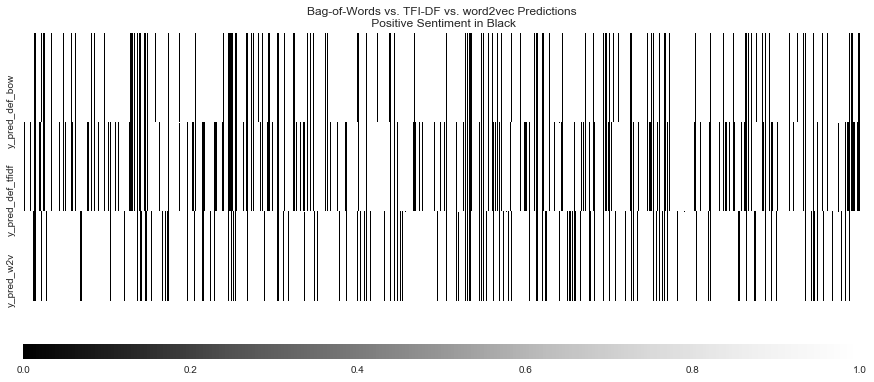

In [137]:
# incorrect predictions for positive sentiment are in black, as we're plotting 0's and 1's
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, 
                                gridspec_kw=grid_kws,
                                figsize=(15, 6))
ax = sns.heatmap(all_reviews[['y_pred_def_bow','y_pred_def_tfidf','y_pred_w2v']][~neg_sentiment].T, 
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"}, cmap="Greys_r",
                 xticklabels=False # don't print the index labels on the x-axis
                )

ax.set_title('Bag-of-Words vs. TFI-DF vs. word2vec Predictions\n Positive Sentiment in Black')
save_fig("bows_tfidf_w2v_pos_sentiment_comparison",tight_layout=False)
plt.show()

Saving figure bows_tfidf_w2v_neg_sentiment_comparison


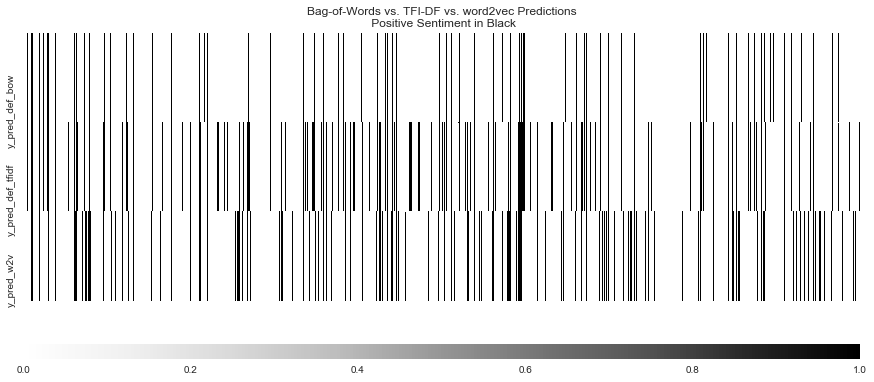

In [138]:
# incorrect predictions for negative sentiment are in black, as we're plotting 0's and 1's
grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, 
                                gridspec_kw=grid_kws,
                                figsize=(15, 6))
ax = sns.heatmap(all_reviews[['y_pred_def_bow','y_pred_def_tfidf','y_pred_w2v']][neg_sentiment].T, 
                 ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"}, cmap="Greys",
                 xticklabels=False # don't print the index labels on the x-axis
                )

ax.set_title('Bag-of-Words vs. TFI-DF vs. word2vec Predictions\n Positive Sentiment in Black')
save_fig("bows_tfidf_w2v_neg_sentiment_comparison",tight_layout=False)
plt.show()

## Tune the best model - word2vec + Logistic Regression
-----

In [139]:
# hyperparams search space
# regularization penalty
penalty = ['l1','l2']

# regularization hyperparameter C's space
# C = 1 / Lambda, small vals increase regularization strength yielding 
# simpler models which tend to underfit the data
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# put together
hyperparams = dict(C=C, penalty=penalty)

In [140]:
# logistic reg model
lr_clf = LogisticRegression()

# create grid to search
grid = GridSearchCV(lr_clf, 
                    hyperparams, 
                    cv=5, 
                    verbose=0)

In [141]:
# do grid search
best_model = grid.fit(X_train_word2vec, y_train_word2vec)

In [142]:
print("Best cross-validation score: {:.2f}".format(best_model.best_score_))
print("Best parameters:\n{}".format(best_model.best_params_))
#print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Best C:', best_model.best_estimator_.get_params()['C'])

Best cross-validation score: 0.82
Best parameters:
{'penalty': 'l2', 'C': 0.1}


Saving figure logistic_regression_word2vec_gridsearch


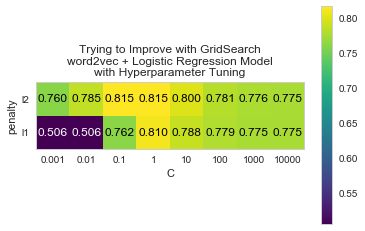

In [143]:
# extract scores from grid_search
scores = best_model.cv_results_['mean_test_score'].reshape(-1, 2).T
# visualize heatmap
heatmap = h.heatmap(scores, 
                    xlabel="C", 
                    ylabel="penalty", 
                    cmap="viridis", 
                    fmt="%.3f",
                    xticklabels=hyperparams['C'],
                    yticklabels=hyperparams['penalty'])
plt.colorbar(heatmap)
plt.title('Trying to Improve with GridSearch\nword2vec + Logistic Regression Model\nwith Hyperparameter Tuning')
save_fig("logistic_regression_word2vec_gridsearch",tight_layout=False)
plt.show()

param_penalty
l1    AxesSubplot(0.125,0.125;0.775x0.755)
l2    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

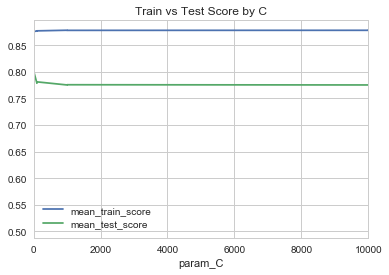

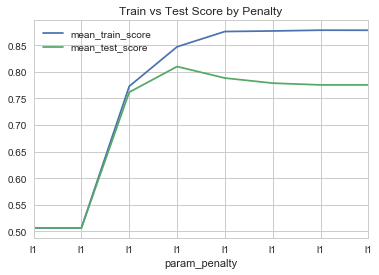

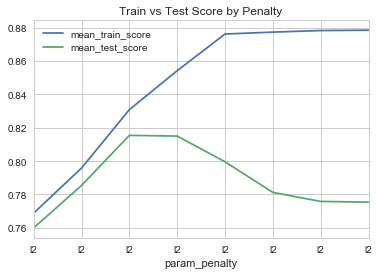

In [144]:
# visualize how the trade-offs between params effects train and test scores
# you can see the sweetspots where the gains in train and test diverge
scores = pd.DataFrame(best_model.cv_results_)
scores[['mean_train_score','mean_test_score']].set_index(scores['param_C']).plot(title='Train vs Test Score by C')
scores[['mean_train_score','mean_test_score']].set_index(scores['param_penalty']).groupby('param_penalty').plot(title='Train vs Test Score by Penalty')

In [145]:
# predict the target from engineered features
y_predicted_word2vec = best_model.predict(X_test_word2vec)

# unpack metrics using function
accuracy, precision, recall, f1 = h.get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.818, precision = 0.822, recall = 0.818, f1 = 0.818


In [146]:
# save off the word2vec best transformer and model
save_model(best_model.best_estimator_,'w2v_best_model.pkl')

Saving model w2v_best_model.pkl


Saving figure logistic_regression_word2vec_gridsearch_best


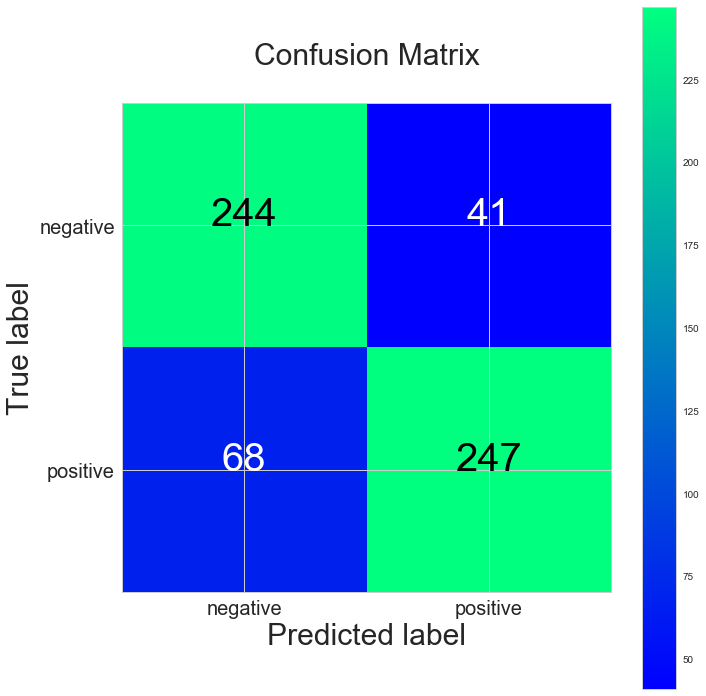

In [147]:
# create a confusion matrix
conf_matrix = h.confusion_matrix(y_test_word2vec, 
                                 y_predicted_word2vec)

# plot the confusion matrix
fig = plt.figure(figsize=(10,10))
plot = h.plot_confusion_matrix(conf_matrix,
                               classes=['negative', 'positive'], #best_model.classes_, 
                               normalize=False, 
                               title='Confusion Matrix\n')

save_fig("logistic_regression_word2vec_gridsearch_best",tight_layout=False)
plt.show()

## Applying a [Voting Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
-----
* a quick attempt at combining the three models to vote on the predictions
* combine best of class for 
  * count-based/CountVectorizer
  * TF-IDF
  * Character NGrams
* applying a soft voting based on the argmax of the sums of predicted probabilities
* applying hard/majority rule classifier for unifying estimators


### NOTE: below are some of the coding challenges I had.
* leaving them on to 
  * demonstrate effort
  * I will likely come back and make it work

In [149]:
# inspired by this code https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/
#def pipelinize(function, active=True):
#    def list_comprehend_a_func(list_or_series, active=True):
#        if active:
#            return [function(i) for i in list_or_series]
#        else:
#            return list_or_series
#    return FunctionTransformer(list_comprehend_a_func, validate=False, kw_args={'active':active})

# this doesn't work...
#pipelinize(get_word2vec_embeddings(word2vec, all_reviews['tokens']))


#from sklearn.preprocessing import FunctionTransformer
#
#def trans_to_w2v_ave(X):
#    
#    # taking the average vector for the document
#    def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
#        '''dataframe column to list
#        '''
#        if len(tokens_list)<1:
#            return np.zeros(k)
#        if generate_missing:
#            vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
#        else:
#            vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
#        length = len(vectorized)
#        summed = np.sum(vectorized, axis=0)
#        averaged = np.divide(summed, length)
#        return averaged
#
#    def get_word2vec_embeddings(vectors, X, generate_missing=False):
#        embeddings = all_reviews['tokens'].apply(lambda x: get_average_word2vec(x, 
#                                                                                vectors, 
#                                                                                generate_missing=generate_missing)
#                                                    )
#        return list(embeddings)
#    
#    
#    if isinstance(X, pd.Series):
#        X.astype('str').apply(lambda x: x.split())
#
#    return get_word2vec_embeddings(word2vec, X)
#
#trans_to_w2v_ave(np.array(all_reviews['tokens'].apply(' '.join)))  

#w2v_ave_embedding_trans = FunctionTransformer(trans_to_w2v_ave)
#w2v_ave_embedding_trans.transform(all_reviews['tokens'].apply(' '.join))
#w2v_ave_embedding_trans.transform(all_reviews['tokens'].apply(' '.join))

In [150]:
from sklearn.ensemble import VotingClassifier

# load Bag-of-Word model
vect = joblib.load('./models/bows_default_2018-08-22.pkl')
lr_clf = joblib.load('./models/logistic_regression_w_bows_2018-08-22.pkl')

# load tfidf rescaled model
tfidf_vect = joblib.load('./models/tfidf_default_2018-08-22.pkl')
lr_clf_2 = joblib.load('./models/logistic_regression_w_tfidf_2018-08-22.pkl')

# load character n-gram model
bocs_vect = joblib.load('./models/bocs_2018-08-28.pkl')
lr_clf3 = joblib.load('./models/logistic_regression_w_bocs_2018-08-28.pkl')

## NOTE: I wanted to use w2v but struggled with the preprossing pipeline
# load the word2vec model
#if ('word2vec' in globals()) & ('word2vec_embeddings' in globals()):
#    #biuld pipeline
#    continue
#else:
#    # load the model
#    word2vec = gensim.models\
#                 .KeyedVectors\
#                 .load_word2vec_format(os.path.join(DATA_PATH,'GoogleNews-vectors-negative300.bin.gz'), 
#                                       binary=True)
#    # then create word2vec embeddings
#    word2vec_embeddings = get_word2vec_embeddings(word2vec, all_reviews)
#    # load the logistic regression model 
#lr_w2v = joblib.load('w2v_best_model.pkl')

# already using the transform the text
bows_lr = Pipeline([('vect', vect),
                     ('lr_clf', lr_clf)])
tfidf_lr = Pipeline([('tfidf_vect', tfidf_vect),
                     ('lr_clf2', lr_clf_2)])
bocs_lr = Pipeline([('bocs_vect', bocs_vect), 
                    ('lr_clf3', lr_clf3)])
#w2v_lr = Pipeline([('w2v_vect', pipelinize(some_funct)),
#                   ('lr_w2v', lr_w2v)])

# models for estimating
models = [('bows_lr', bows_lr), 
          ('tfidf_lr', tfidf_lr), #,('w2v_lr', w2v_lr)
          ('bocs_lr', bocs_lr)
         ]

In [151]:
# first, try soft voting - predicts the class label based on 
# the argmax of the sums of the predicted probabilities
vote_soft = VotingClassifier(estimators=models, 
                             voting='soft'
                            )
vote_soft.fit(all_reviews['tokens'].apply(' '.join), 
              reviews_features['score']
             )
soft_vote_preds = vote_soft.predict(all_reviews['tokens'].apply(' '.join))
soft_vote_preds

array([0, 0, 0, ..., 0, 0, 0])

In [152]:
# work through models to get predicted probabilities
probs = [c.fit(all_reviews['tokens'].apply(' '.join), 
               all_reviews['score']
              )\
           .predict_proba(all_reviews['tokens'].apply(' '.join))\
         for c in (bows_lr, tfidf_lr, bocs_lr, vote_soft)
        ]

# get the target predicted probability for the voting classifier
probs[2][:,1]

array([  2.28249960e-02,   7.98118771e-03,   5.34552420e-06, ...,
         2.10575414e-01,   6.01414035e-02,   2.44204442e-02])

Saving figure soft_voting_confusion_matrix


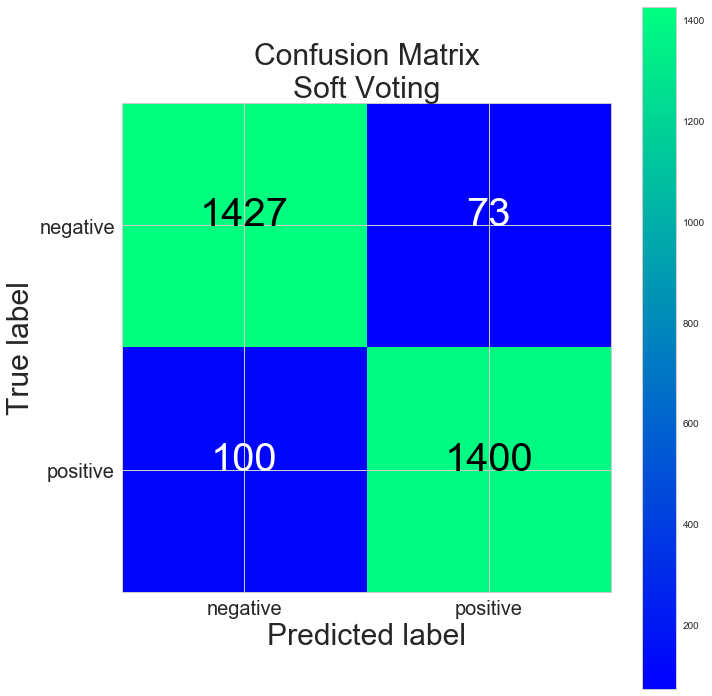

In [153]:
# soft predictions confusion matrix
conf_matrix = h.confusion_matrix(all_reviews['score'], soft_vote_preds)

# plot the confusion matrix
fig = plt.figure(figsize=(10,10))
h.plot_confusion_matrix(conf_matrix,
                        classes=['negative','positive'], 
                        normalize=False, 
                        title='Confusion Matrix\nSoft Voting')

save_fig("soft_voting_confusion_matrix",tight_layout=False)

In [154]:
# unpack metrics using function
accuracy, precision, recall, f1 = h.get_metrics(all_reviews['score'], soft_vote_preds)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.942, precision = 0.942, recall = 0.942, f1 = 0.942


In [155]:
all_reviews['y_soft_vote'] = soft_vote_preds
mistakes = all_reviews['score'] != all_reviews['y_soft_vote']
# observations: mistakes are consistently made with positive sentiment
# imdb had ~45-50% more errors, which could likely change over a larger dataset and more training
g = all_reviews[mistakes].groupby(['source','score'])['source'].size() / 500 #.plot(kind='bar')
g = pd.DataFrame(g).rename(columns={'source':'mistakes_pct'}).reset_index()
g

,source,score,mistakes_pct
0,amazon,0,0.044
1,amazon,1,0.064
2,imdb,0,0.048
3,imdb,1,0.060
4,yelp,0,0.054
5,yelp,1,0.076


Saving figure soft_voting_mistakes


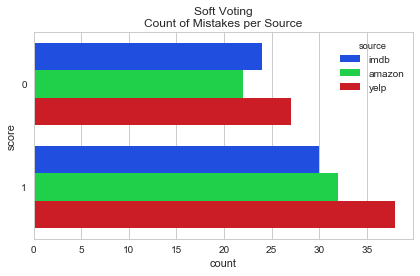

In [156]:
# plot the mistakes
ax = sns.countplot(y='score', 
                   hue='source', 
                   data=all_reviews[['source','score']][mistakes], 
                   palette='bright')
plt.title('Soft Voting\nCount of Mistakes per Source')
save_fig("soft_voting_mistakes")
plt.show()

In [176]:
# next, try hard voting - predicted class labels for majority rule voting
vote_hard = VotingClassifier(estimators=models, 
                             voting='hard'
                            )

vote_hard.fit(all_reviews['tokens'].apply(' '.join), 
              reviews_features['score']
             )

hard_vote_preds = vote_hard.predict(all_reviews['tokens'].apply(' '.join))
hard_vote_preds

array([0, 0, 0, ..., 0, 0, 0])

Saving figure hard_voting_confusion_matrix


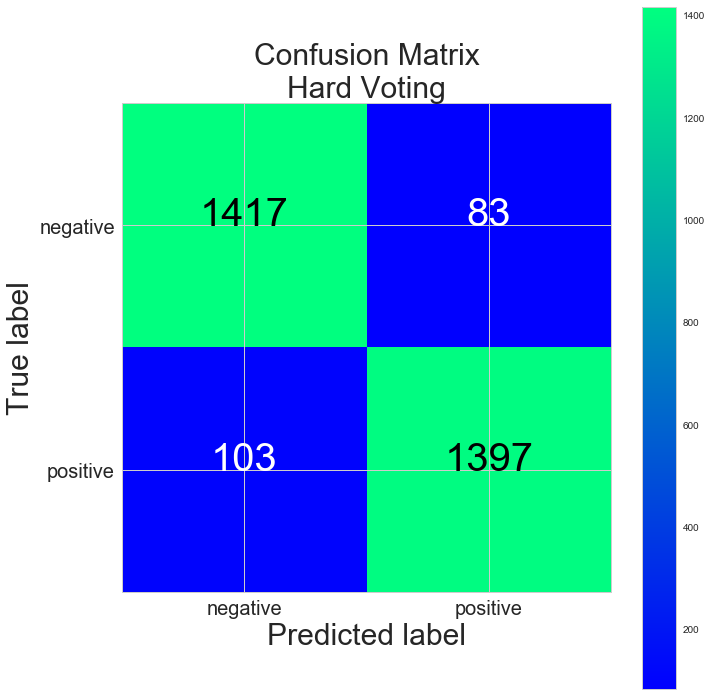

In [177]:
# soft predictions confusion matrix
conf_matrix = h.confusion_matrix(all_reviews['score'], hard_vote_preds)

# plot the confusion matrix
fig = plt.figure(figsize=(10,10))
h.plot_confusion_matrix(conf_matrix,
                        classes=['negative','positive'], 
                        normalize=False, 
                        title='Confusion Matrix\nHard Voting')

save_fig("hard_voting_confusion_matrix",tight_layout=False)

In [178]:
# unpack metrics using function
accuracy, precision, recall, f1 = h.get_metrics(all_reviews['score'], hard_vote_preds)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.938, precision = 0.938, recall = 0.938, f1 = 0.938


In [180]:
all_reviews['y_hard_vote'] = hard_vote_preds
mistakes = all_reviews['score'] != all_reviews['y_hard_vote']
# observations: mistakes are consistently made with positive sentiment
# imdb had ~45-50% more errors, which could likely change over a larger dataset and more training
g = all_reviews[mistakes].groupby(['source','score'])['source'].size() / 500 #.plot(kind='bar')
g = pd.DataFrame(g).rename(columns={'source':'mistakes_pct'}).reset_index()
g

,source,score,mistakes_pct
0,amazon,0,0.046
1,amazon,1,0.066
2,imdb,0,0.062
3,imdb,1,0.066
4,yelp,0,0.058
5,yelp,1,0.074


Saving figure hard_voting_mistakes


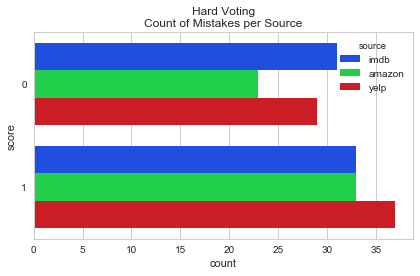

In [181]:
# plot the mistakes
ax = sns.countplot(y='score', 
                   hue='source', 
                   data=all_reviews[['source','score']][mistakes], 
                   palette='bright')
plt.title('Hard Voting\nCount of Mistakes per Source')
save_fig("hard_voting_mistakes")
plt.show()

In [162]:
# work through models to get predicted probabilities
# NOTE: predict_proba not avail for hard voting
#hard_probs = [c.fit(all_reviews['tokens'].apply(' '.join), 
#               all_reviews['score']
#              )\
#           .predict(all_reviews['tokens'].apply(' '.join))\
#         for c in (bows_lr, tfidf_lr, vote_hard)
#        ]
#
## get the target predicted probability for the voting classifier
#hard_probs[2]

In [163]:
display(all_reviews.info())
# get the predicted columns
keep_cols = [col for col in all_reviews.columns if (('pred' in col) | 
                                                    ('score' in col) | 
                                                    ('document' in col) | ('source' in col)
                                                   )]

# save off predictions
all_reviews[keep_cols].to_csv(os.path.join(MODEL_PATH, 'all_reviews_predictions.csv'))
display(all_reviews[keep_cols].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
document                   3000 non-null object
score                      3000 non-null int32
source                     3000 non-null object
len                        3000 non-null int64
tokens                     3000 non-null object
y_pred_def_bow             3000 non-null int32
y_pred_prob_def_bow_0      3000 non-null float64
y_pred_prob_def_bow_1      3000 non-null float64
y_pred_def_tfidf           3000 non-null int32
y_pred_prob_def_tfidf_0    3000 non-null float64
y_pred_prob_def_tfidf_1    3000 non-null float64
custom_tokens              3000 non-null object
y_pred_w2v                 3000 non-null int32
y_pred_prob_w2v0           3000 non-null float64
y_pred_prob_w2v1           3000 non-null float64
y_soft_vote                3000 non-null int32
y_hard_vote                3000 non-null int32
dtypes: float64(6), int32(6), int64(1), object(4)
memory usage: 328.2+ KB


None

,document,score,source,y_pred_def_bow,y_pred_prob_def_bow_0,y_pred_prob_def_bow_1,y_pred_def_tfidf,y_pred_prob_def_tfidf_0,y_pred_prob_def_tfidf_1,y_pred_w2v,y_pred_prob_w2v0,y_pred_prob_w2v1
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,imdb,0,0.848500,0.151500,0,0.787071,0.212929,0,0.813841,0.186159
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,imdb,0,0.881240,0.118760,0,0.813371,0.186629,0,0.662359,0.337641
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,imdb,0,0.925928,0.074072,0,0.701568,0.298432,0,0.785355,0.214645
3,Very little music or anything to speak of.,0,imdb,0,0.720162,0.279838,0,0.587974,0.412026,0,0.719649,0.280351
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,imdb,1,0.237407,0.762593,1,0.393404,0.606596,1,0.454621,0.545379


### observations on voting
* both hard and soft voting performed similarly

In [164]:
# save the voting models
save_model(vote_soft, 'vote_soft')
save_model(vote_hard, 'vote_hard')

Saving model vote_soft
Saving model vote_hard


## Test Sentences from urbandictionary.com
-----
The idea is to grab and label polarized sentences from yet another source. This will help demonstrate if the model is generalizing well, investigate any shortcomings/look for inspiration for ideas of improvement.

In summary, these work pretty well. The ones that were missed, would be challenging even as a human, without more context like speaker's disposition/bias, or word intention/meanings. 

Also, using a strategy of the two highest probabilites per class would do quite nicely. An example is Index 2 "Nah, that place is a total touristaurant, my food was awful last time I ate there." where Bag-of-Words choked but the other two models were within the top quartile of predicting negative sentiment.

In [165]:
# document & score
contrived_sents = [("Expensive restaurants with horrible food that people still go to for the prime location or atmosphere.", 0), 
 ("It has a beautiful view of the Eiffel Tower!", 1),
 ("Nah, that place is a total touristaurant, my food was awful last time I ate there.", 0),
 ("I had a great day, climbed a hill and didn't check facebook.", 1),
 ("That corgi-shaped macaron is expensive because it's got instagram tax.", 1),
 ("That 1962 Alfa Romeo is good for transportainment", 1),
 ("not so great for getting to work in the snow", 0),
 ("This is so sad Alexa play despacito", 0),
 ("This better not escalate to Dutch ovens any time soon...", 0),
 ("Oh. It has too many calories for me. Well, OK.", 1),
 ("Mmm, this pizza is some good food.", 1),
 ("Food's better for throwing at someone than eating.", 0), 
 ("Are you finished with your restau-rant? I get it, we're outta here. Let's pay the check and leave.", 0),
 ("The Primrose Bar and Restaurant in Ballynahinch, Co. Down in the north of Ireland is one of the best in the country. ",  1),
 ("This burger is crappy.", 0),
 ("DUDE! I got buffungled by Amazon.com with a 8-12 day shipping time!", 0),
 ("I am going to <b>BUY</b> that game RIGHT NOW.", 1),
 ("wow, that was great!", 1),
 ("That movie was great!", 1),
 ("The computer crashed again. I lost three thousand lines of code.", 0)
]

df_contrived = pd.DataFrame(contrived_sents,columns=['document','score'])
df_contrived.head()

,document,score
0,Expensive restaurants with horrible food that people still go to for the prime location or atmosphere.,0
1,It has a beautiful view of the Eiffel Tower!,1
2,"Nah, that place is a total touristaurant, my food was awful last time I ate there.",0
3,"I had a great day, climbed a hill and didn't check facebook.",1
4,That corgi-shaped macaron is expensive because it's got instagram tax.,1


## Let's predict on the individual best models

In [166]:
# predict on the three models and review

# CountVecorizer and LogisticRegression models
# transform and predict
x_bows = vect.transform(df_contrived['document'].as_matrix())
y_pred_proba_bows = lr_clf.predict_proba(x_bows)

df_contrived['bows_0'] = y_pred_proba_bows[:,0]
df_contrived['bows_1'] = y_pred_proba_bows[:,1]

In [167]:
# TfidfVectorizer and LogisticRegression models
# transform and predict
x_tfidf = tfidf_vect.transform(df_contrived['document'].as_matrix())
y_pred_proba_x_tfidf = lr_clf_2.predict_proba(x_tfidf)

df_contrived['tfidf_0'] = y_pred_proba_x_tfidf[:,0]
df_contrived['tfidf_1'] = y_pred_proba_x_tfidf[:,1]

In [168]:
# word2vec and Logistic Regression

# clean the data
df_contrived['tokens'] = df_contrived["document"].apply(h.replace_contractions) \
                                               .apply(nltk.word_tokenize) \
                                               .apply(h.normalize) \
                                               .apply(h.lemmatize_verbs)
display(df_contrived[['document','tokens']].head())

# create the embeddings using gensim
word2vec_embeddings = get_word2vec_embeddings(word2vec,
                                              all_reviews=df_contrived)

# predict the test set with the trained word2vec + Logistic Regression model
#y_pred_w2v = lr_clf_w2v.predict(word2vec_embeddings)
y_pred_proba_w2v = lr_clf_w2v.predict_proba(word2vec_embeddings)

df_contrived['w2v_0'] = y_pred_proba_w2v[:,0]
df_contrived['w2v_1'] = y_pred_proba_w2v[:,1]

,document,tokens
0,Expensive restaurants with horrible food that people still go to for the prime location or atmosphere.,"[expensive, restaurants, horrible, food, people, still, go, prime, location, atmosphere]"
1,It has a beautiful view of the Eiffel Tower!,"[beautiful, view, eiffel, tower]"
2,"Nah, that place is a total touristaurant, my food was awful last time I ate there.","[nah, place, total, touristaurant, food, awful, last, time, eat]"
3,"I had a great day, climbed a hill and didn't check facebook.","[great, day, climb, hill, check, facebook]"
4,That corgi-shaped macaron is expensive because it's got instagram tax.,"[corgishaped, macaron, expensive, get, instagram, tax]"


In [169]:
# load character n-gram model
bocs_vect = joblib.load('./models/bocs_2018-08-28.pkl')
lr_bocs = joblib.load('./models/logistic_regression_w_bocs_2018-08-28.pkl')

bocs = bocs_vect.transform(df_contrived['tokens'].apply(' '.join))
bocs_pred = lr_bocs.predict(bocs)
df_contrived['bocs_pred'] = bocs_pred

In [170]:
df_contrived.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
document     20 non-null object
score        20 non-null int64
bows_0       20 non-null float64
bows_1       20 non-null float64
tfidf_0      20 non-null float64
tfidf_1      20 non-null float64
tokens       20 non-null object
w2v_0        20 non-null float64
w2v_1        20 non-null float64
bocs_pred    20 non-null int64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.6+ KB


## Now, let's try the two voting classifiers

In [171]:
# load the models
vote_soft = joblib.load('./models/vote_soft_2018-08-29.pkl')
vote_hard = joblib.load('./models/vote_hard_2018-08-29.pkl')


vote_soft.transform(df_contrived['tokens'].apply(' '.join))

soft_vote_preds = vote_soft.predict(df_contrived['tokens'].apply(' '.join))
df_contrived['soft_vote_pred'] = soft_vote_preds

C:\Anaconda3\envs\tf-nlp-gpu\lib\site-packages\sklearn\ensemble\voting_classifier.py:290: DeprecationWarning: 'flatten_transform' default value will be changed to True in 0.21.To silence this warning you may explicitly set flatten_transform=False.
  DeprecationWarning)


In [172]:
vote_hard.transform(df_contrived['tokens'].apply(' '.join))

hard_vote_preds = vote_hard.predict(df_contrived['tokens'].apply(' '.join))
df_contrived['hard_vote_pred'] = hard_vote_preds

In [173]:
contrived_summary = df_contrived[['document','score',
                                  'bows_1','tfidf_1','w2v_1','bocs_pred',
                                  'hard_vote_pred','soft_vote_pred']]
contrived_summary.to_csv(os.path.join(MODEL_PATH, r'contrived_model_predictions.csv'))

## What else?
* we could explore topic modelling and dig into particular topics which may be challenging/error prone.
* something like below.

In [174]:
# explore topics on the urbandictionary.com sentences
from gensim import corpora
dictionary = corpora.Dictionary(df_contrived['tokens'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_reviews['tokens']]
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=50)
print(ldamodel.print_topics())

[(0, '0.172*"good" + 0.142*"food" + 0.134*"place" + 0.111*"go" + 0.091*"get" + 0.057*"best" + 0.052*"well" + 0.039*"eat" + 0.027*"us" + 0.017*"pizza"'), (1, '0.167*"great" + 0.115*"time" + 0.110*"one" + 0.100*"movie" + 0.080*"work" + 0.041*"better" + 0.033*"restaurant" + 0.030*"still" + 0.027*"buy" + 0.026*"right"')]


## Conclusion
-----
Sentiment analysis is challenging in practice, due to many of the constraints of models. Often times, the size of the text being classified is a factor. The longer the text, the less accurate the classification simply because there is a greater chance of ambiguity. Additionally, tuning a model to a particular data source may provide better metrics at the likely cost of sacrificing the generalizable model. And, as is true with most text-based tasks, the more data the better the model can be, which is dependent upon human or perhaps a semi-supervised method to get enough labels for modelling. 

In this capstone, we aimed at creating a generalizable model. Hence, the data chosen was aggregated from three separate sources: reviews from Yelp, Amazon, and iMDB. The idea being that in order to create a more generalizable model, the more diverse the data the better. The data is diverse from a site perspective, a product/industry perspective, and a language usage perspective (proper prose all the way to the gutter). The driver for chosing the models in this CapStone was immediate ease of interpretability, which is necessary in my industry for business/model validation committes et al buy-in/adoption.

The experiment was begun by calculating a naive predictor as the baseline. Then, a default model baseline was established with minimal preprocessing and a simple frequency count to bag of words utilized by a linear regression model for classification (sklearn.CountVectorizer + sklearn.LogisticRegression). This baseline was then compared to a similar approach but switching out a a simple count frequency data representation for sklearn.TfidfVectorizer. Both results were very similar. However, one interesting observation was that even though the two models' metrics were similar, the actual instances where mistakes were made had sufficient non-overlap that a strategy could be devised to achieve higher metrics than just using either model individually.

Next, hand-crafted feature engineering was tried by thinking about constructing features on information that might be lost due to preprocessing (removing punctuation, lower casing words, unusual and misspelled words, the richness of text, the fractions of stop words, etc.). Even with the use of grid search among six different models, the results were below the baseline of linear regression on a simple bag of words. This was extremely dissappointing as it involved a large time commitment. However it also goes to demonstrate the power of this simple model.

Finally, a distributed vector was tried using a word2vec model created by Google researchers. The main advantages here is its ability to utilize words which have not been seen in the training data, as well as allowing for comparing similarities via vectors, either on the word-level or the document level. To incorporate the word2vec model, an average vector was created per document, which was then fed to Logistic Regression for prediction. This model was a noted improvement above the simple Bag of Words baseline. But, when an attempt was made to improve upon the word2vec + Logistic Regression model, via grid search, there wasn't much to be gained, so it would be better to use the first version.

With the three strongest models being so close in terms of metrics, I collected some contrived sentences from UrbanDictionary.com and labelled them myself. Then, I predicted sentiment with the three models for comparison. This sort of technique seems feasable to explore weakness in the model. Using a strategy of the two highest probabilites per class did quite nicely, in this small sample.

Also attempted was the implementation of a Bag-of-Characters model also using Logistic Regression. The model performed surprisingly well given it's small size. Then, combining all of the best models, a voting learner was utilized with all of the best models - both hard and soft voting. 

With all of this in mind, there are many interesting routes to pursue for increased performance. First steps might be gathering more data for training, and trying different representations of data like part-of-speech and named entity recognition. Casting a wider net on models utilized, perhaps even state-of-the-art, is published enough to make it worthwhile to experiment. So, naturally LSTMs and CNNs come to mind as next steps. And, with exciting and recently published techniques like LIME (local Interpretable Model-Agnostic Explanations) the door may have swung a little wider to acceptable models in the business' eyes.

### References Aides
-----
* [should I normalize/standardize/rescale the data](http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html)
* [sklearn LogisticRegression docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_log_proba)
* [About Logistic Regressions from stats.stackexchange](https://stats.stackexchange.com/questions/24405/analyzing-logistic-regression-coefficients)
* [Plot class probabilities calculated by the VotingClassifier](http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html#sphx-glr-auto-examples-ensemble-plot-voting-probas-py)
* [python-graph-gallery](https://python-graph-gallery.com/33-control-colors-of-boxplot-seaborn/)
* [vector space model](https://en.wikipedia.org/wiki/Vector_space_model) - applications in relevance rankings, most common being cosine similarity and tf-idf (which is good for short docs but not long ones - b/c similarity becomes less w/ length)
* [latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing)

* Gensim word2vec
  * **[Gensim](https://radimrehurek.com/gensim/)** – Topic Modelling for Humans
  * [Google's paper](https://code.google.com/archive/p/word2vec/), code for word2vec, and published pre-trained word2vec model (~1.6 GB file size)
  * [Google Open Source Blog - Learning the meaning behind words, 2013](https://opensource.googleblog.com/2013/08/learning-meaning-behind-words.html)
  * [Learning Representations of Text using Neural Networks, Tomas Mikolov, 2013](https://docs.google.com/file/d/0B7XkCwpI5KDYRWRnd1RzWXQ2TWc/edit)
  * [gensim word2vec embeddings - for missing words](https://radimrehurek.com/gensim/models/word2vec.html)
  * [gensim word2vec tutorial](https://rare-technologies.com/word2vec-tutorial/#app)
  * [machine learning mastery word2vec and GloVe](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

* arXiv papers
  * [Enriching Word Vectors with Subword Information, Piotr Bojanowski](https://arxiv.org/abs/1607.04606)
  * [The Evolution of Sentiment Analysis - A Review of Research Topics, Venues, and Top Cited Papers](https://arxiv.org/ftp/arxiv/papers/1612/1612.01556.pdf)
  * [Assessing State-of-the-Art Sentiment Models on State-of-the-Art Sentiment Datasets](http://www.aclweb.org/anthology/W17-5202)
  * [Distributed Representations of Words and Phrases and their Compositionality, Tomas Mikolov, 2013](https://arxiv.org/pdf/1310.4546.pdf)
  * [Efficient Estimation of Word Representations in Vector Space, Thomas Mikolov, 2013](https://arxiv.org/pdf/1301.3781.pdf)

### Reference Notes
-------

  * **Noise Reduction** - removing non-relevant text to the context of the data (stop words, URLs/links, social media entities, punctuations and industry specific words, etc.)
  * **Lexicon Normalization** - feature engineering step by converting versions of a word into a lemma, effectively reducing dimensionality
    * stemming - rule-based, removing suffixes
    * lemmatization - obtaining root form of word, using a vocabulary (standard lexical dictionary for importance of words) and morphological analysis (word structure and grammar relations)
  * **Object Standardization** - often using regex to handle non-standard speech like acronyms, hashtags, and slang by creating a dictionary and a lookup method to map and replace such objects.
  * **Syntactic Parsing** - 
    * **Dependency Grammar** - dependency trees finding root word of sentence with subtrees, making use of tripplets (relation, governor, dependent)
    * **Part of Speech (POS) tags** - nouns, adjectives, adverbs, ett. but in finer detail like in this [Penn Treebank project list](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
      * reduces word ambiguities, when can have several meanings
      * feature engineering, improving word-based features enabling models to learn proper context w/ the tag
      * normalization and lemmatization based on POS tags
      * efficient stopword removal by tagging low fequency words
  * **Entity Extraction** - 
    * **Named Entity Recognition (NER)** consists of blocks
      * noun phrase id - uses dependency parcing and pos tagging
      * phrase classification - noun phrases to categories
      * entity disambiguation - a validation layer to correct misclassified entities, typically using knowledge graphs like [Google Knowledge Graph](https://www.google.com/intl/en_us/insidesearch/features/search/knowledge.html) or IBM Watson and Wikipedia
    * **Topic Modeling** - id topics present in a corpus
      * Latent Dirichlet Allocation [(LDA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) is popular
      * [On Finding the Natural Number of Topics with Latent Dirichlet Allocation: Some Observations, R. ArunV. SureshC. E. Veni MadhavanM. N. Narasimha Murthy](https://link.springer.com/chapter/10.1007%2F978-3-642-13657-3_43)
  
  * **Text Summarization** - taking large text data and reducing to most important and relevant topics/sentences
  
  * **Machine Translation** - translating between human languages, using grammar, semantics and real world info
  
  * **Natural Language Generation and Understanding** - converting information from text data or semantic intents into human-readable text. This can include constructing more logical structures, as a preprocessing step for models
  
  * **Optical Character Recognition** -convert visual images of text to text data
  
  * **Document to Information** - preprocessing like parsing text data from sources to standard formats for analyzing/modeling


